# Notebook 2 - Análise Exploratória de dados

# Libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime as dt
from datetime import datetime
from unidecode import unidecode
%matplotlib inline

sns.set(style="whitegrid")
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100000000)
pd.set_option('display.width', 400)

# Funções úteis

In [2]:
# variaveis categoricas
def plot_univariate_bar(x, df, figsize = (10,5), rot = 0, palette='viridis'):
    
    plt.figure( figsize = figsize)
    
    percentage = df[x].value_counts(normalize=True).values * 100
    
    ax = sns.countplot(
        x = x, 
        data = df,
        palette = palette, 
        order = df[x].value_counts().index
    )
    
    patches = ax.patches
    for i in range(len(patches)):
        a = patches[i].get_x() + patches[i].get_width()/2
        b = patches[i].get_height()+.05
        ax.annotate('{:.1f}%'.format(percentage[i]), (a, b), ha='center', fontsize=12)

    plt.title("Distribuição da variável {}".format(x), fontsize = 20)
    plt.xlabel(x, fontsize = 20)
    plt.ylabel("Contagem", fontsize = 15)
    plt.xticks(rotation=rot)
    plt.show()
    
def plot_bivariate_bar(x, df, hue='status_emp', figsize=(10,5), rot=0, palette='viridis'):
    
    plt.figure(figsize=figsize)
    
#     percentage = df.groupby(hue)[x].value_counts(normalize=True).unstack(hue).values.reshape(1,-1)[0] * 100    
    ax = sns.countplot(
        x = x, 
        hue = hue, 
        data = df,
        palette = palette, 
        order = df[x].value_counts(ascending=False).index
    )
    
#     patches = ax.patches
#     for i in range(len(patches)):
#         a = patches[i].get_x() + patches[i].get_width()/2
#         b = patches[i].get_height()+.05
#         ax.annotate('{:.1f}%'.format(percentage[i]), (a, b), ha='center', fontsize=20)
    
    plt.title("Distribuição da variável {} - quebra por {}".format(x, hue), fontsize = 20)
    plt.xlabel(x, fontsize = 20)
    plt.ylabel("Contagem", fontsize = 16)
    plt.xticks(rotation = rot)
    plt.show()
    
#variaveis numericas continuas
def plot_univariate_continuos_var( df, x,  color_dist = 'blue', color_boxplot = 'red', showfliers=True):
    
    fig, axes = plt.subplots(1,2, figsize=(15,5))

    sns.distplot(
        df[x], 
        kde=True, 
        color = color_dist,
        ax = axes[0])

    sns.boxplot(
        df[x], 
        color = color_boxplot,
        showfliers = showfliers,
        ax = axes[1]
    )

    axes[0].set_title('Distribuição da variável {}'.format(x))
    axes[1].set_title('Boxplot da variável {}'.format(x))
    axes[0].set_ylabel('Contagem')
    
    plt.show()
    
def plot_bivariate_continuos_var( df, x, hue='status_emp', color_kde='blue', palette="Set2",showfliers=True):
    
    fig, axes = plt.subplots(1,2, figsize=(15,5))
    
    sns.kdeplot(
        data = df, 
        x = x, 
        hue = hue,
        color = color_kde,
        ax = axes[0]
    )
    
    sns.boxplot(
        data = df, 
        y = x, 
        x = hue, 
        palette = palette,
        showfliers = showfliers,
        ax = axes[1]
    )

    axes[0].set_title('KDE plot da variável {} - Quebra por {}'.format(x, hue))
    axes[1].set_title('Boxplot da variável {} - Quebra por {}'.format(x, hue))
    axes[0].set_ylabel('Contagem')
    
    plt.show()
    
def get_profissao_categoria(DF, mapper):
    df = DF.copy()
    df['emprego_categoria'] = 'outro'
    for k, v in mapper.items():
        #df.loc[df['nome_emprego'].str.contains(v, regex=True), 'emprego_categoria'] = k
        df.loc[df['nome_emprego'].str.contains(v, regex=True), 'emprego_categoria'] = k
    return df    

#### Lendo a base

In [3]:
df1 = pd.read_csv("loan_cleaned.csv")
print(df1.shape)

(862074, 48)


In [4]:
df1.head()

id  loan_amnt        term  int_rate  installment grade sub_grade             emp_title emp_length home_ownership  annual_inc verification_status     issue_d  loan_status                                                url             purpose               title zip_code addr_state   dti earliest_cr_line  fico_range_low  fico_range_high  open_acc  pub_rec  revol_bal  revol_util  \
0  68407277    3600.00   36 months     13.99       123.03     C        C4               leadman  10+ years       MORTGAGE    55000.00        Not Verified  2015-12-01            0  https://lendingclub.com/browse/loanDetail.acti...  debt_consolidation  Debt consolidation    190xx         PA  5.91         Aug-2003          675.00           679.00      7.00     0.00    2765.00       29.70   
1  68355089   24700.00   36 months     11.99       820.28     C        C1              Engineer  10+ years       MORTGAGE    65000.00        Not Verified  2015-12-01            0  https://lendingclub.com/browse/loanDetail.acti...      small_business            Business    577xx         SD 16.06         Dec-1999          715.00           719.00     22.00     0.00   21470.00       19.20   
2  68341763   20000.00   60 months     10.78       432.66     B        B4          truck driver  10+ years       MORTGAGE    63000.00        Not Verified  2015-12-01            0  https://lendingclub.com/browse/loanDetail.acti...    home_improvement                 NaN    605xx         IL 10.78         Aug-2000          695.00           699.00      6.00     0.00    7869.00       56.20   
3  68476807   10400.00   60 months     22.45       289.91     F        F1   Contract Specialist    3 years       MORTGAGE   104433.00     Source Verified  2015-12-01            0  https://lendingclub.com/browse/loanDetail.acti...      major_purchase      Major purchase    174xx         PA 25.37         Jun-1998          695.00           699.00     12.00     0.00   21929.00       64.50   
4  68426831   11950.00   36 months     13.44       405.18     C        C3  Veterinary Tecnician    4 years           RENT    34000.00     Source Verified  2015-12-01            0  https://lendingclub.com/browse/loanDetail.acti...  debt_consolidation  Debt consolidation    300xx         GA 10.20         Oct-1987          690.00           694.00      5.00     0.00    8822.00       68.40   

   total_acc initial_list_status application_type  open_acc_6m  open_act_il  open_il_12m  open_il_24m  mths_since_rcnt_il  total_bal_il  il_util  open_rv_12m  open_rv_24m  max_bal_bc  all_util  inq_fi  total_cu_tl  inq_last_12m  mo_sin_old_il_acct  mo_sin_old_rev_tl_op  mort_acc  pub_rec_bankruptcies  
0      13.00                   w       Individual         2.00         2.00         0.00         1.00               21.00       4981.00    36.00         3.00         3.00      722.00     34.00    3.00         1.00          4.00              148.00                128.00      1.00                  0.00  
1      38.00                   w       Individual         1.00         1.00         0.00         1.00               19.00      18005.00    73.00         2.00         3.00     6472.00     29.00    0.00         0.00          6.00              113.00                192.00      4.00                  0.00  
2      18.00                   w        Joint App         0.00         1.00         0.00         4.00               19.00      10827.00    73.00         0.00         2.00     2081.00     65.00    2.00         5.00          1.00              125.00                184.00      5.00                  0.00  
3      35.00                   w       Individual         1.00         3.00         0.00         3.00               14.00      73839.00    84.00         4.00         7.00     9702.00     78.00    2.00         1.00          3.00              128.00                210.00      6.00                  0.00  
4       6.00                   w       Individual         0.00         1.00         0.00         0.00              338.00       3976.00    99.

In [5]:

list_cols = { 
    'id' : 'id' ,
    'loan_amnt' : 'volume_emp' ,
    'term' : 'prazo' ,
    'int_rate' : 'taxa_juros' ,
    'installment' : 'prestacao' ,
    'grade' : 'score' ,
    'sub_grade' : 'sub_score' ,
    'emp_title' : 'nome_emprego' ,
    'emp_length' : 'anos_emprego' ,
    'home_ownership' : 'casa_propria' ,
    'annual_inc' : 'renda_anual' ,
    'verification_status' : 'status_verificacao' ,
    'issue_d' : 'mes_inic_emp' ,
    'loan_status' : 'status_emp' ,
    'url' : 'url' ,
    'purpose' : 'proposito_emp' ,
    'title' : 'titulo_emp' ,
    'zip_code' : 'zip_code' ,
    'addr_state' : 'estado_endereco' ,
    'dti' : 'razao_pag_inc',
    'earliest_cr_line' : 'primeira_linha_cred' ,
    'fico_range_low' : 'fico_lim_min' ,
    'fico_range_high' : 'fico_lim_max' ,
    'open_acc' : 'linhas_cred_abertas' ,
    'pub_rec' : 'reg_pub_depreciativos' ,
    'revol_bal' : 'saldo_rot_total' ,
    'revol_util' : 'taxa_uso_linha_rot' ,
    'total_acc' : 'total_linha_cred_abertas' ,
    'initial_list_status' : 'status_init' ,
    'application_type' : 'tipo_emp' ,
    'open_acc_6m' : 'linhas_abertas_m6' ,
    'open_act_il' : 'prest_abertas' ,
    'open_il_12m' : 'prest_abertas_m12' ,
    'open_il_24m' : 'prest_abertas_m24' ,
    'mths_since_rcnt_il' : 'meses_ultimo_cred' ,
    'total_bal_il' : 'saldo_contas_prest' ,
    'il_util' : 'razao_saldo_lim_cred' ,
    'open_rv_12m' : 'negociacoes_abertas_m12' ,
    'open_rv_24m' : 'negociacoes_abertas_m24' ,
    'max_bal_bc' : 'saldo_atual_max' ,
    'all_util' : 'saldo_cred' ,
    'inq_fi' : 'qtd_consultas_cred' ,
    'total_cu_tl' : 'qtd_negociacoes_cred' ,
    'inq_last_12m' : 'qtd_consultas_cred_m12' ,
    'mo_sin_old_il_acct' : 'meses_primeira_abert_prestacoes' ,
    'mo_sin_old_rev_tl_op' : 'meses_primeira_abert_conta_rot' ,
    'mort_acc' : 'qtd_hipotecas' ,
    'pub_rec_bankruptcies' : 'num_falencias'
}

In [6]:
df1.rename(columns = list_cols, inplace=True)

In [7]:
df1.head()

id  volume_emp       prazo  taxa_juros  prestacao score sub_score          nome_emprego anos_emprego casa_propria  renda_anual status_verificacao mes_inic_emp  status_emp                                                url       proposito_emp          titulo_emp zip_code estado_endereco  razao_pag_inc primeira_linha_cred  fico_lim_min  fico_lim_max  linhas_cred_abertas  \
0  68407277     3600.00   36 months       13.99     123.03     C        C4               leadman    10+ years     MORTGAGE     55000.00       Not Verified   2015-12-01           0  https://lendingclub.com/browse/loanDetail.acti...  debt_consolidation  Debt consolidation    190xx              PA           5.91            Aug-2003        675.00        679.00                 7.00   
1  68355089    24700.00   36 months       11.99     820.28     C        C1              Engineer    10+ years     MORTGAGE     65000.00       Not Verified   2015-12-01           0  https://lendingclub.com/browse/loanDetail.acti...      small_business            Business    577xx              SD          16.06            Dec-1999        715.00        719.00                22.00   
2  68341763    20000.00   60 months       10.78     432.66     B        B4          truck driver    10+ years     MORTGAGE     63000.00       Not Verified   2015-12-01           0  https://lendingclub.com/browse/loanDetail.acti...    home_improvement                 NaN    605xx              IL          10.78            Aug-2000        695.00        699.00                 6.00   
3  68476807    10400.00   60 months       22.45     289.91     F        F1   Contract Specialist      3 years     MORTGAGE    104433.00    Source Verified   2015-12-01           0  https://lendingclub.com/browse/loanDetail.acti...      major_purchase      Major purchase    174xx              PA          25.37            Jun-1998        695.00        699.00                12.00   
4  68426831    11950.00   36 months       13.44     405.18     C        C3  Veterinary Tecnician      4 years         RENT     34000.00    Source Verified   2015-12-01           0  https://lendingclub.com/browse/loanDetail.acti...  debt_consolidation  Debt consolidation    300xx              GA          10.20            Oct-1987        690.00        694.00                 5.00   

   reg_pub_depreciativos  saldo_rot_total  taxa_uso_linha_rot  total_linha_cred_abertas status_init    tipo_emp  linhas_abertas_m6  prest_abertas  prest_abertas_m12  prest_abertas_m24  meses_ultimo_cred  saldo_contas_prest  razao_saldo_lim_cred  negociacoes_abertas_m12  negociacoes_abertas_m24  saldo_atual_max  saldo_cred  qtd_consultas_cred  qtd_negociacoes_cred  qtd_consultas_cred_m12  \
0                   0.00          2765.00               29.70                     13.00           w  Individual               2.00           2.00               0.00               1.00              21.00             4981.00                 36.00                     3.00                     3.00           722.00       34.00                3.00                  1.00                    4.00   
1                   0.00         21470.00               19.20                     38.00           w  Individual               1.00           1.00               0.00               1.00              19.00            18005.00                 73.00                     2.00                     3.00          6472.00       29.00                0.00                  0.00                    6.00   
2                   0.00          7869.00               56.20                     18.00           w   Joint App               0.00           1.00               0.00               4.00              19.00            10827.00                 73.00                     0.00                     2.00          2081.00       65.00                2.00                  5.00                    1.00   
3                   0.00         21929.00               64.50                     35.00           w  Individual               1.00        

# 4 - Data Viz

In [8]:
df2 = df1.copy()

In [9]:
cat_vars = df2.select_dtypes(include= 'object')
num_vars = df2.select_dtypes(exclude= 'object')

## 4.1 - Variável Target

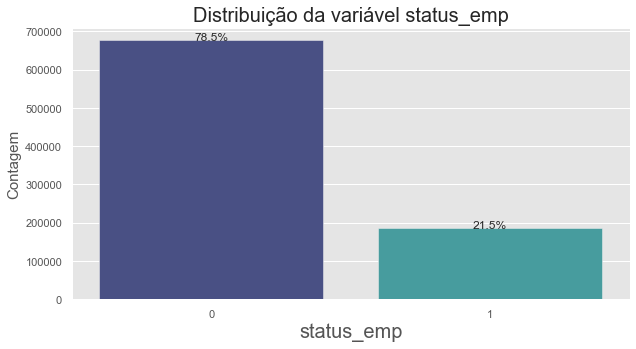

In [10]:
#plot para análise univariada
plot_univariate_bar("status_emp",df2, palette = 'mako')

In [11]:
df2.status_emp.value_counts(normalize=True)

0   0.78
1   0.22
Name: status_emp, dtype: float64

## 4.2 Variáveis categóricas

### 1. Prazo

In [12]:
df2['prazo'].value_counts(normalize=True)

 36 months   0.77
 60 months   0.23
Name: prazo, dtype: float64

In [13]:
df2.groupby('prazo')['status_emp'].value_counts(normalize=True).to_frame()

status_emp
prazo      status_emp            
 36 months 0                 0.82
           1                 0.18
 60 months 0                 0.65
           1                 0.35

In [ ]:
status_emp  prazo     
0            36 months   0.81
             60 months   0.19
1            36 months   0.62
             60 months   0.38

In [97]:
df2.groupby('status_emp')['prazo'].value_counts(normalize=True)

status_emp  prazo     
0            36 months   0.81
             60 months   0.19
1            36 months   0.62
             60 months   0.38
Name: prazo, dtype: float64

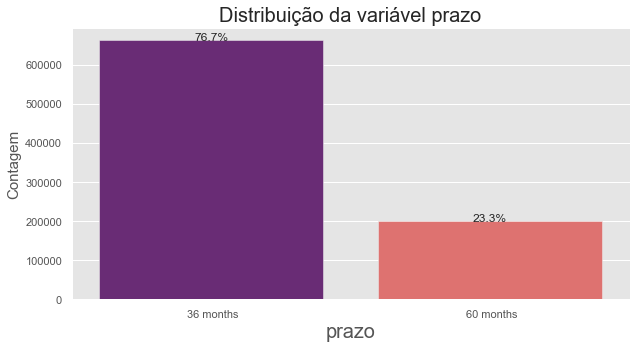

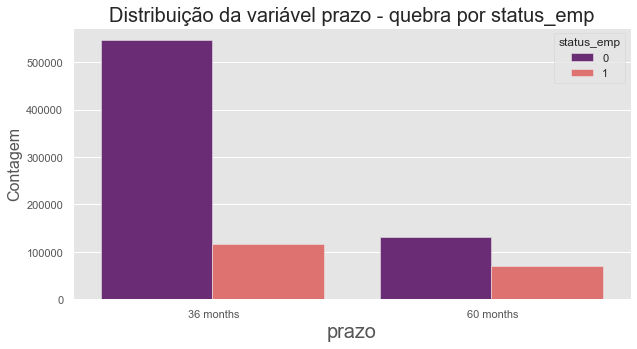

In [14]:
#plot para análise univariada
plot_univariate_bar("prazo",df2, palette='magma')

#plot para análise bivariada
plot_bivariate_bar("prazo", df2,palette='magma')

Do gráfico acima para 'prazo', podemos observar que o número de empréstimos com prazo de 36 meses é maior, comparado com 60 meses.

Quando observamos a distribuição por status_emp(target) podemos observar que o número de inadimplentes é maior para empréstimos com prazo de 36 meses, porém não é uma diferença expressiva.

**Prazo é interessante -> Sim**

### 2. Score

In [15]:
df2['score'].value_counts(normalize=True)

C   0.29
B   0.29
A   0.18
D   0.14
E   0.07
F   0.02
G   0.01
Name: score, dtype: float64

In [16]:
df2.groupby('score')['status_emp'].value_counts(normalize=True).to_frame()

status_emp
score status_emp            
A     0                 0.94
      1                 0.06
B     0                 0.85
      1                 0.15
C     0                 0.76
      1                 0.24
D     0                 0.66
      1                 0.34
E     0                 0.58
      1                 0.42
F     1                 0.51
      0                 0.49
G     1                 0.54
      0                 0.46

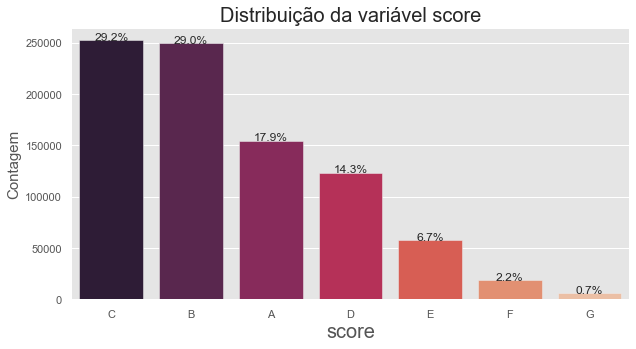

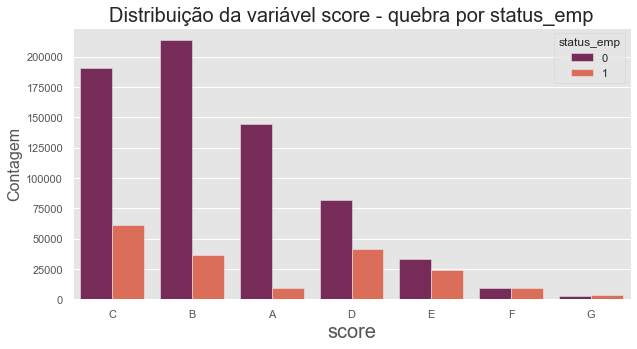

In [17]:
#plot para análise univariada
plot_univariate_bar("score",df2, palette='rocket')

#plot para análise bivariada
plot_bivariate_bar("score", df2,palette='rocket')

Para a variável score do empréstimo, podemos observar que a contagem é expressiva para as classes A, B e C.

Na análise bivariada podemos observar que empréstimos de score C, B e D tem mais chance de não serem pagos.

**Score é interessante -> Sim**

### 3. Sub_score

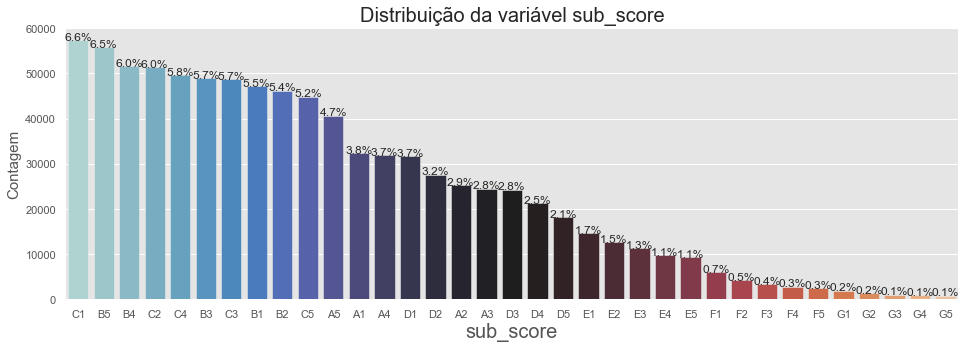

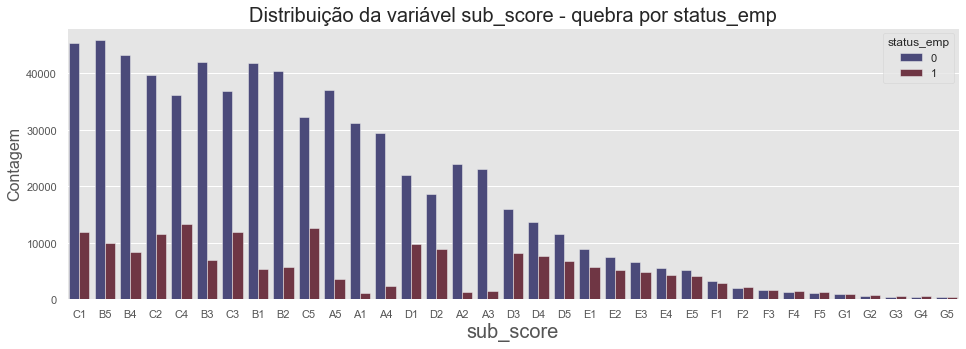

In [18]:
#plot para análise univariada
plot_univariate_bar("sub_score",df2, palette='icefire',figsize=(16,5))

#plot para análise bivariada
plot_bivariate_bar("sub_score", df2,palette='icefire',figsize=(16,5))

Para variável sub_score, os segmentos mais expressivos podem ser observados a partir de D4. A contagem para o grupo C1 chega próxima a 60.000 empréstimos nessa categoria.

Na análise bivariada, podemos observar que a taxa de inadimplentes está variando em relação ao sub_score, portanto, sendo as chances de o empréstimo ser prejudicado maior nos sub_scores C1, B5, B4, C2, C4, C3,C5, D1, D2,D3 e D4.

**Sub_grade é interessante -> Sim**

### 4. casa_propria

In [19]:
df2['casa_propria'].value_counts(normalize=True)

MORTGAGE   0.49
RENT       0.39
OWN        0.12
ANY        0.00
NONE       0.00
Name: casa_propria, dtype: float64

In [20]:
df2.groupby('casa_propria')['status_emp'].value_counts(normalize=True).to_frame()

status_emp
casa_propria status_emp            
ANY          0                 0.80
             1                 0.20
MORTGAGE     0                 0.82
             1                 0.18
NONE         0                 1.00
OWN          0                 0.78
             1                 0.22
RENT         0                 0.74
             1                 0.26

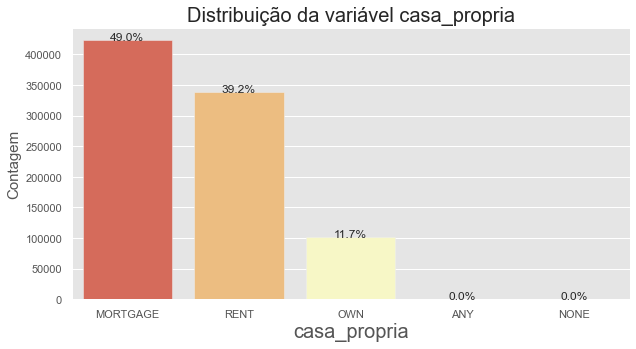

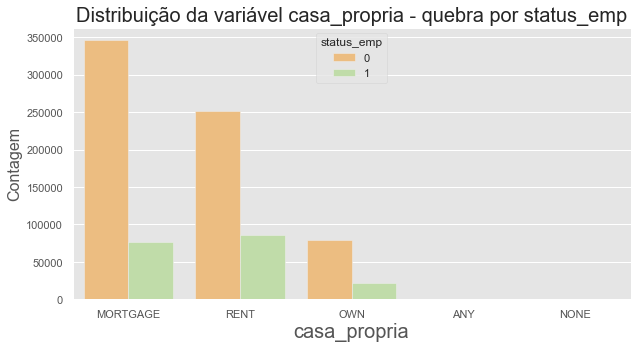

In [21]:
#plot para análise univariada
plot_univariate_bar("casa_propria",df2, palette='Spectral')

#plot para análise bivariada
plot_bivariate_bar("casa_propria", df2, palette='Spectral')

Para variável casa_propria, no primeiro gráfico podemos observar que a maior parte dos empréstimos se divide respectivamente nos perfis mortgage(hipoteca), rent(aluguel) e own(própria).

Do segundo gráfico, podemos inferir que a coluna rent é a que contém mais indivíduos da classe 1, porém existe pouca variação entre os grupos.

**home_ownership é interessante -> Não**

### 5. status_verificacao

In [22]:
df2['status_verificacao'].value_counts(normalize=True)

Source Verified   0.42
Not Verified      0.30
Verified          0.28
Name: status_verificacao, dtype: float64

In [23]:
df2.groupby('status_verificacao')['status_emp'].value_counts(normalize=True).to_frame()

status_emp
status_verificacao status_emp            
Not Verified       0                 0.84
                   1                 0.16
Source Verified    0                 0.78
                   1                 0.22
Verified           0                 0.73
                   1                 0.27

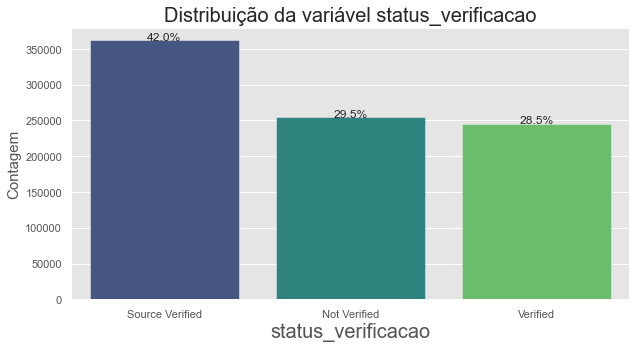

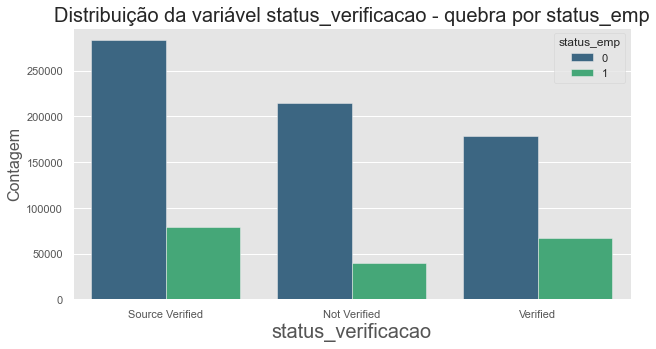

In [24]:
#plot para análise univariada
plot_univariate_bar("status_verificacao",df2)

#plot para análise bivariada
plot_bivariate_bar("status_verificacao",df2)

Para variável status_verificacao, podemos observar que tanto os status verificados e não verificados estão igualmente distribuídos, enquanto que Source Verified se destaca entre as três.

Na análise bivariada, é interessante observar que o número de eventos default é maior nas categorias source verified e verified quando comparadas com not verified (usuários não verificados).

**status_verificacao é interessante -> Não**

### 6. proposito_emp

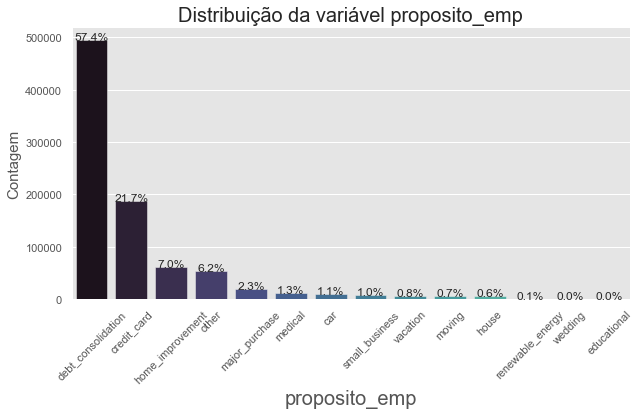

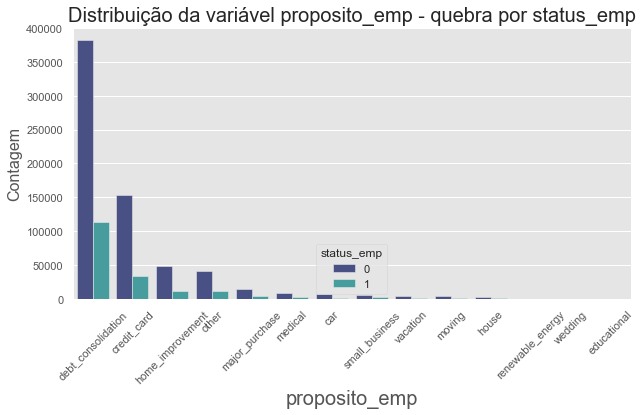

In [25]:
#plot para análise univariada
plot_univariate_bar("proposito_emp",df2, rot = 45, palette='mako')

#plot para análise bivariada
plot_bivariate_bar("proposito_emp",df2,rot = 45, palette='mako')

Para variável proposito_emp (propósito do empréstimo), podemos observar que a grande maioria dos empréstimos é feita para debt_consolidation, seguida por credit_card e home_improvement.

Do gráfico acima para proposito_emp, podemos inferir que a taxa de inadimplência é maior para as categorias já citadas no primeiro gráfico (debt_consolidation, credit_card).

**propósito é interessante -> Sim**

### 7. anos_emprego

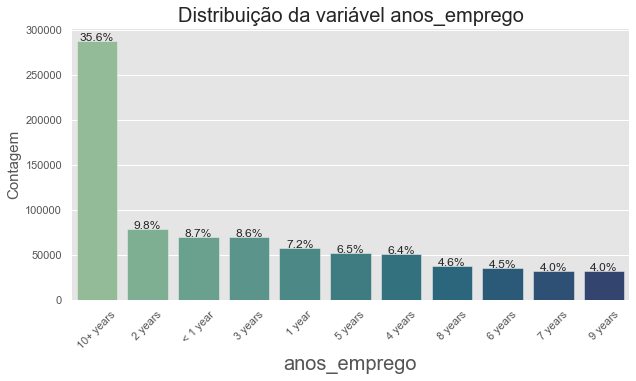

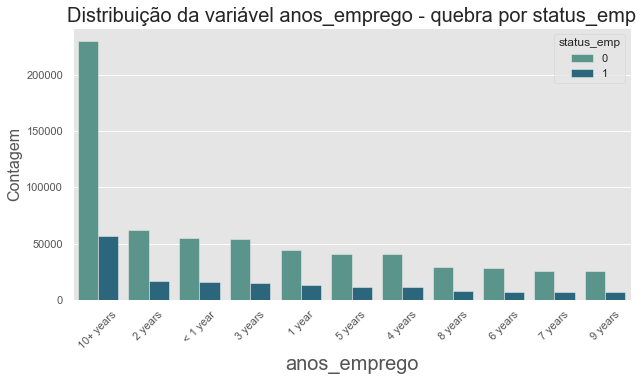

In [26]:
#plot para análise univariada
plot_univariate_bar("anos_emprego",df2, rot = 45, palette='crest')

#plot para análise bivariada
plot_bivariate_bar("anos_emprego",df2,rot = 45, palette='crest')

Para a variável anos_emprego, podemos observar que a maioria dos contratantes de empréstimo possuem 10 anos ou mais no emprego atual.

Na análise bivariada, pode-se observar que a taxa de inadimplentes é quase constante aqui, portanto, o evento pode não ter correlação com a variável de anos_emprego

**anos_emprego é interessante -> Não**

### 8. estado_endereço

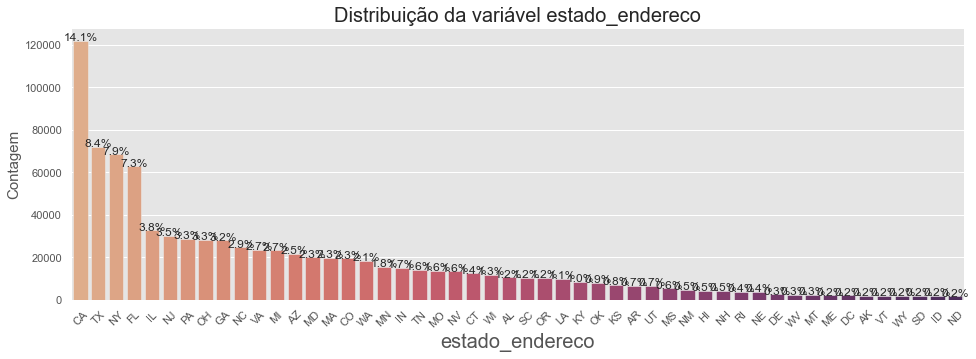

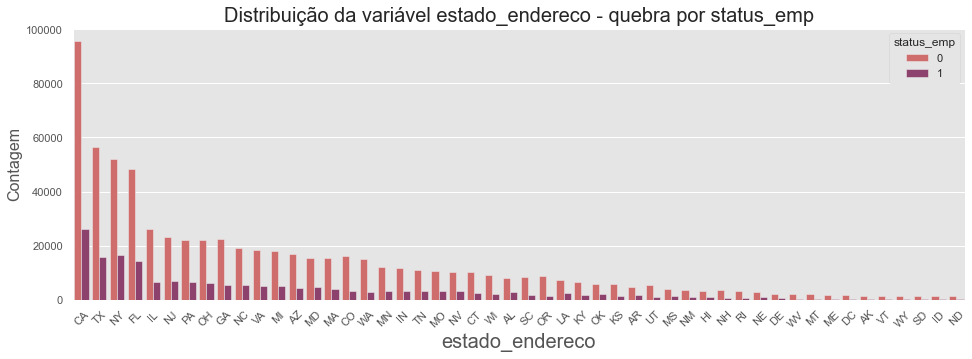

In [27]:
#plot para análise univariada
plot_univariate_bar("estado_endereco",df2, rot = 45, palette='flare',figsize=(16,5))

#plot para análise bivariada
plot_bivariate_bar("estado_endereco",df2,rot = 45, palette='flare',figsize=(16,5))

- estados com maior número de empréstimos e consequentemente maior inadimplencia: CA (california), TX (texas), NY (new york) e FL (Florida)

### 9. primeira_linha_cred

In [28]:
df2['primeira_linha_cred'] = df2['primeira_linha_cred'].astype('datetime64[ns]').dt.year

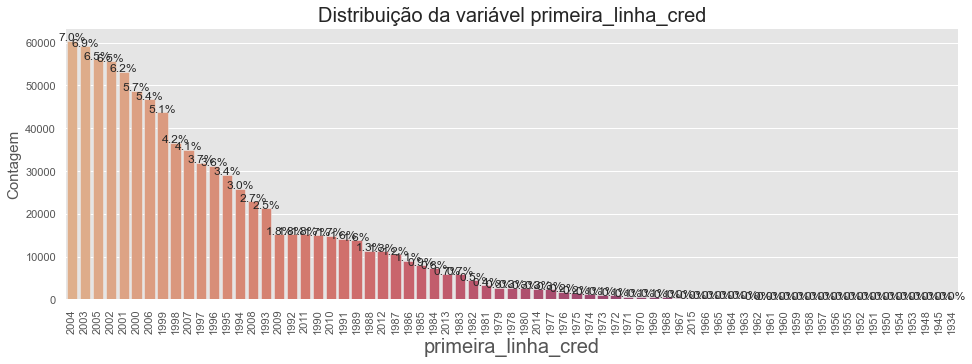

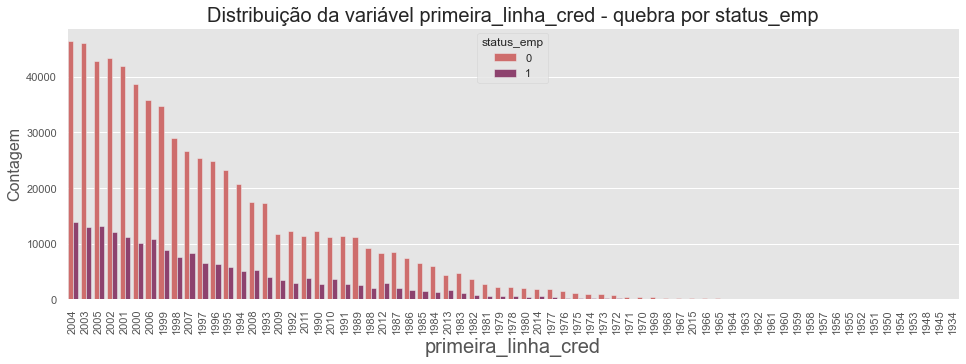

In [29]:
#plot para análise univariada
plot_univariate_bar("primeira_linha_cred",df2, rot = 90, palette='flare',figsize=(16,5))

#plot para análise bivariada
plot_bivariate_bar("primeira_linha_cred",df2,rot = 90, palette='flare',figsize=(16,5))

### 10. status_init

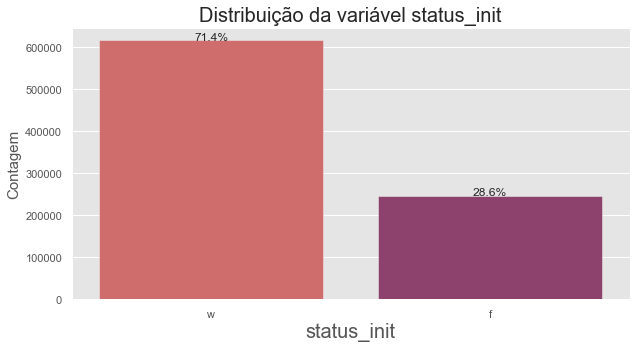

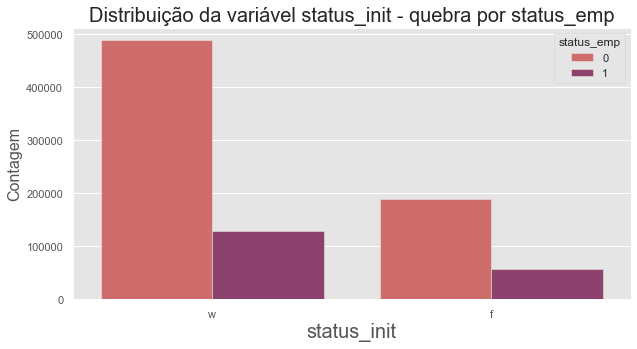

In [30]:
#plot para análise univariada
plot_univariate_bar("status_init",df2, palette='flare')

#plot para análise bivariada
plot_bivariate_bar("status_init",df2, palette='flare')

w = whole
f = fractional

### 11. Tipo_emp

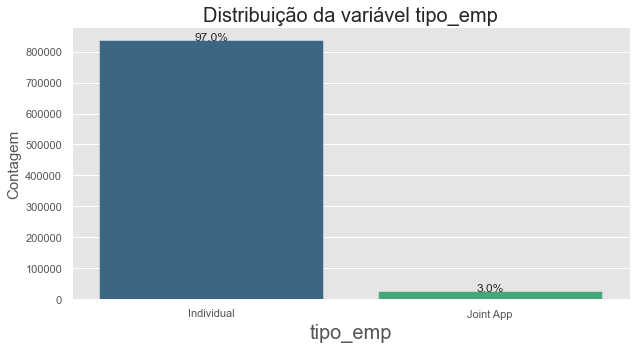

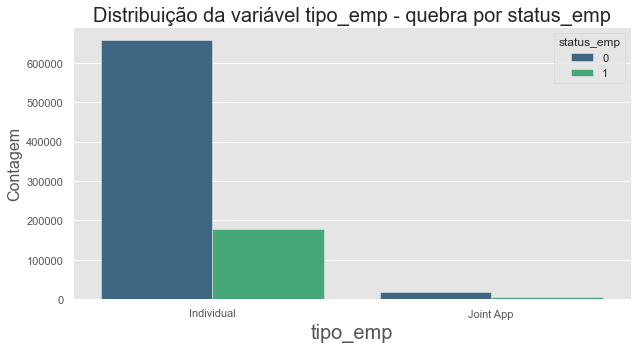

In [31]:
#plot para análise univariada
plot_univariate_bar("tipo_emp",df2)

#plot para análise bivariada
plot_bivariate_bar("tipo_emp",df2)

In [100]:
df2.groupby('tipo_emp')['status_emp'].value_counts(normalize=True)

tipo_emp    status_emp
Individual  0            0.79
            1            0.21
Joint App   0            0.75
            1            0.25
Name: status_emp, dtype: float64

### 12. emprego_categoria

In [32]:
df2['nome_emprego'].fillna('sem_info', inplace=True)
df2['nome_emprego'] = df2['nome_emprego'].apply(
    lambda x: unidecode(x.lower())
)

In [33]:
MAPPER_PROFISSOES = {
        'engenharia':'(operato|eng|engineer)',
        'autonomo':'(owner|driver)',
        'area_medica':'(health|physician|clinical|pharmacist|nurse|medical|dental|paramedic|nutritionist)',
        'banco':'(teller|bank|accountant|accounting|credit)',
        'educacao':'(dean|educator|teacher|prof|student)',
        'funcionario publico':'(social|deputy|auditor|secreatary|typist|social|maintenance|public|counselor|resources|rep|custodian)',
        'militar':'(lieutenant|pilot|capitain|salor)',
        'gerencia_diretoria':'(coord.|vice-president|captain|leader|director|lead|coordinator|coord.|principal|president|leadman|manager)',
        'comercial':'(sales|officer|administrator|salesman|buyer)',
        'area_tecnica':'(agent|quality|electrician|analyst|specialist|tech|control|supervisor|electrical|producer|professional|scientist|technician|operations|inspector|mechanic|operation|anylist|paraprofessional)',
        'financeira':'(financial|business|executive|consultant)',
        'temporary_jobs':'(bartender|cashier|teller)',
        'gerais': '(clerk|server|customer service|foreman|machinist|secretary|assistant)',
        'direito':'(paralegal|legal|lawyer|assurance|associate|attorney)',
    }


In [34]:
df2 = get_profissao_categoria(df2, MAPPER_PROFISSOES)

In [35]:
df2['emprego_categoria'].value_counts()

outro                  241212
gerencia_diretoria     166210
area_tecnica           142645
gerais                  53284
comercial               52101
autonomo                37428
engenharia              31462
financeira              29743
educacao                26014
area_medica             25445
direito                 21532
funcionario publico     19206
banco                    9987
temporary_jobs           4263
militar                  1542
Name: emprego_categoria, dtype: int64

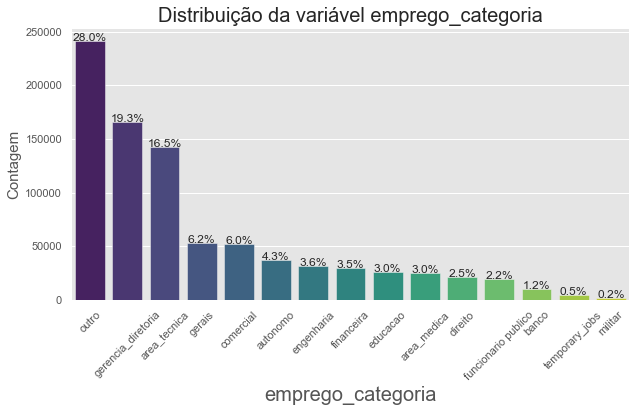

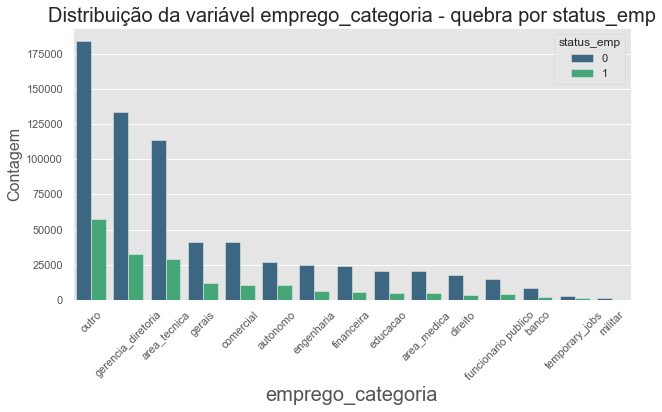

In [36]:
#plot para análise univariada
plot_univariate_bar("emprego_categoria",df2,rot=45)

#plot para análise bivariada
plot_bivariate_bar("emprego_categoria",df2,rot=45)

## 4.3. Variáveis numéricas

### 1. volume_emp

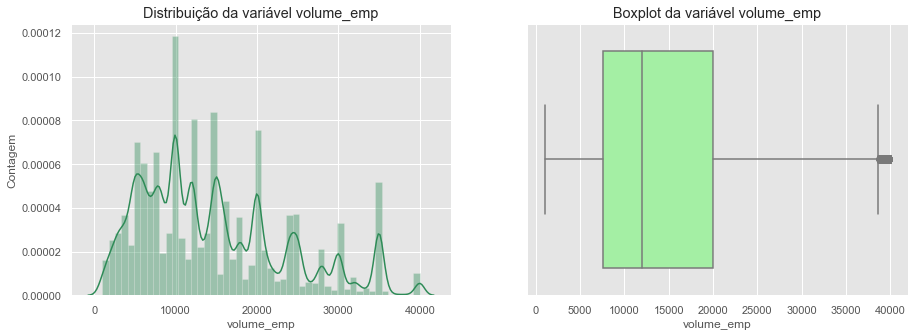

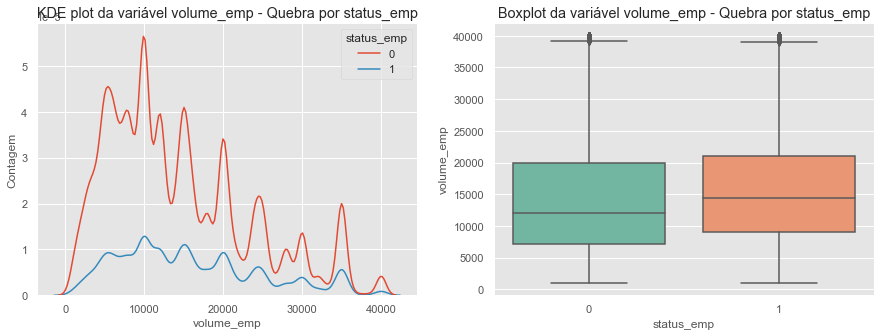

In [37]:
#plot para análise univariada
plot_univariate_continuos_var(df2, "volume_emp", color_dist = 'seagreen', color_boxplot = 'palegreen')

#plot para análise bivariada
plot_bivariate_continuos_var(df2, "volume_emp")

Para variável volume_emp, podemos observar que grande parte dos empréstimos se encontra entre 6.000-20.000, e vai reduzindo a medida que o valor do empréstimo aumenta.

No segundo gráfico, podemos observar que a taxa de inadimplência parece ser maior para empréstimos maiores do que para os de valores inferiores.

**volume_emp é interessante -> Sim**

### 2. taxa_juros

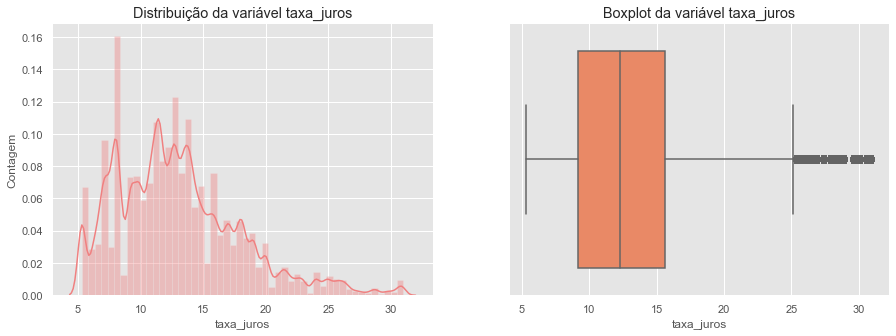

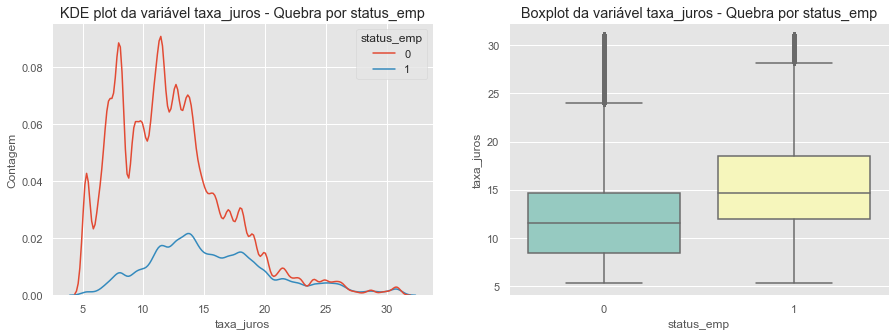

In [38]:
#plot para análise univariada
plot_univariate_continuos_var(df2, "taxa_juros", color_dist = 'lightcoral', color_boxplot = 'coral')

#plot para análise bivariada
plot_bivariate_continuos_var(df2, "taxa_juros", palette = 'Set3')

Para a variável taxa_juros, podemos observar que as taxas se concentram entre 10 e 15%.
No segundo gráfico, podemos comparar a taxa de  default com emprestimos pagos e a medida que a taxa de juros aumenta, a probabilidade de default também aumenta.

**taxa_juros é interessante -> Sim**

### 3. prestacao

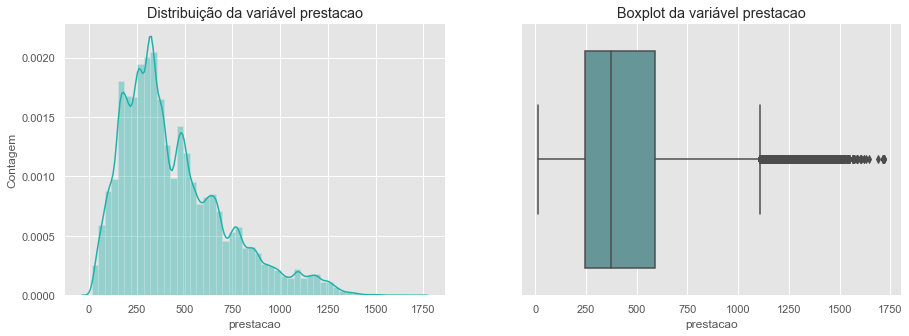

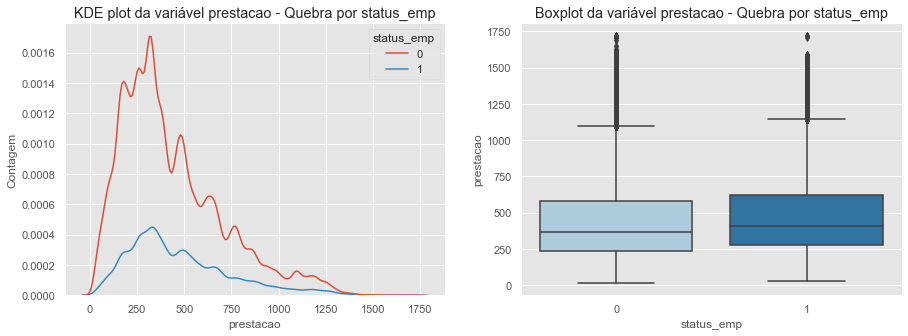

In [39]:
#plot para análise univariada
plot_univariate_continuos_var(df2, "prestacao", color_dist = 'lightseagreen', color_boxplot = 'cadetblue')

#plot para análise bivariada
plot_bivariate_continuos_var(df2, "prestacao", palette = 'Paired')

Para variável installment, observamos que grande parte dos dados está concentrada em 250-300 prestações.

No segundo bloco de gráficos, podemos inferir que a taxa de inadimplentes é mais alto com o aumento das parcelas, mas a diferença é bem discreta.

**prestacao é interessante -> Sim**

### 4. Renda anual

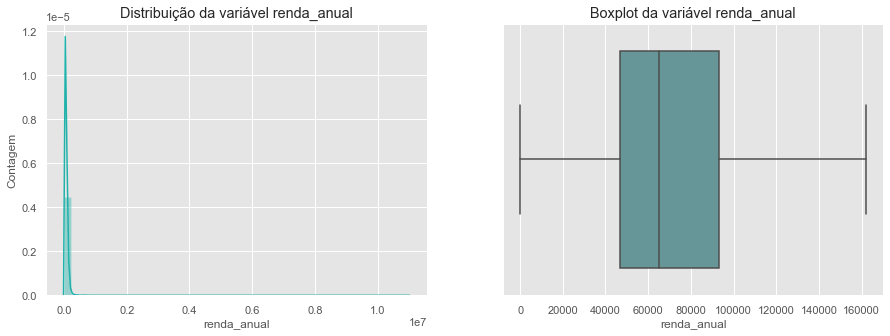

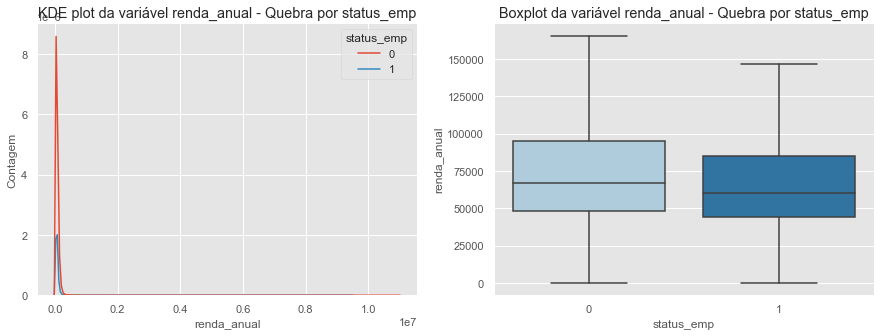

In [40]:
#plot para análise univariada
plot_univariate_continuos_var(df2, "renda_anual", color_dist = 'lightseagreen', color_boxplot = 'cadetblue', showfliers=False)

#plot para análise bivariada
plot_bivariate_continuos_var(df2, "renda_anual", palette = 'Paired',showfliers=False )

Para variável renda_anual, temos que a maioria dos contratantes dos empréstimos possui renda anual entre 50.000-90.000.

A partir do gráfico acima para ‘renda_anual’, podemos inferir que a taxa de inadimplentes está diminuindo a medida que os valores renda_anual aumentam.

**renda_anual é interessante -> Sim**

### 5. razao_pag_inc

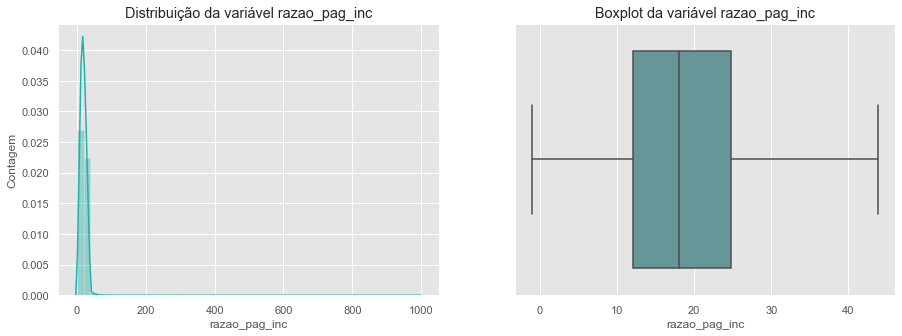

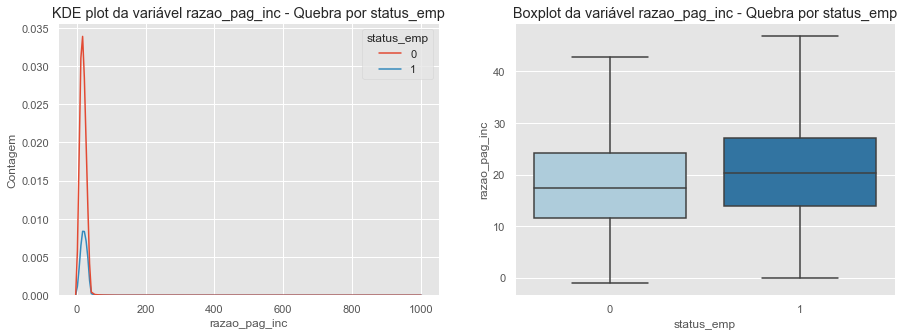

In [41]:
#plot para análise univariada
plot_univariate_continuos_var(df2, "razao_pag_inc", color_dist = 'lightseagreen', color_boxplot = 'cadetblue',showfliers=False)

#plot para análise bivariada
plot_bivariate_continuos_var(df2, "razao_pag_inc", palette = 'Paired',showfliers=False)

Para a variável razao_pag_inc, podemos observar que este índice concentra uma grande parte dos empréstimos entre 15 e 25%.

Do gráfico acima para ‘razao_pag_inc’ podemos inferir que a taxa de inadimplência está aumentando com os valores razao_pag_inc, portanto, o evento pode ter correlação com a variável razao_pag_inc

**razao_pag_inc é interessante -> Sim**

### 6. Fico_score

Dicionário de dados para fico_lim_min: "O limite inferior ao qual pertence o FICO do mutuário na origem do empréstimo."
Dicionário de dados para fico_lim_max: "O limite superior ao qual pertence o FICO do mutuário na origem do empréstimo."

In [42]:
df3 = df2.copy()

In [43]:
df3[['fico_lim_min','fico_lim_max']].describe()

fico_lim_min  fico_lim_max
count     862074.00     862074.00
mean         696.32        700.32
std           32.45         32.45
min          660.00        664.00
25%          670.00        674.00
50%          690.00        694.00
75%          710.00        714.00
max          845.00        850.00

In [44]:
df3[['fico_lim_min','fico_lim_max']].corr()

fico_lim_min  fico_lim_max
fico_lim_min          1.00          1.00
fico_lim_max          1.00          1.00

Essas duas variáveis são altamente correlacionadas, portanto, só precisamos manter uma. Criamos uma nova variável, "fico_score" que é o valor médio de "fico_lim_min" e "fico_lim_max"


In [45]:
df3['fico_score'] = (df3['fico_lim_min'] + df3['fico_lim_max'])/2.\

In [46]:
df3.drop(['fico_lim_max', 'fico_lim_min'], axis=1, inplace=True)

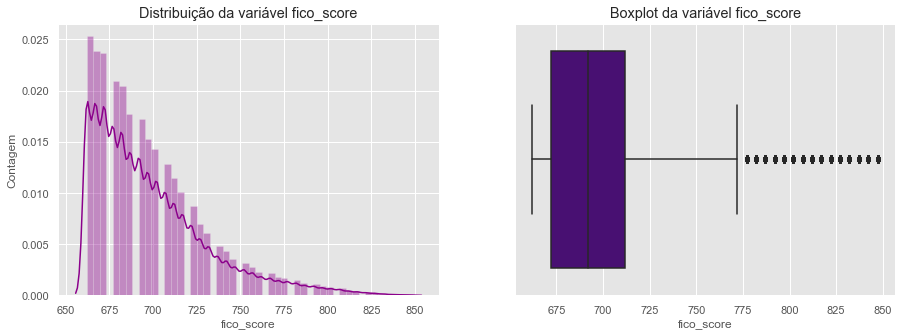

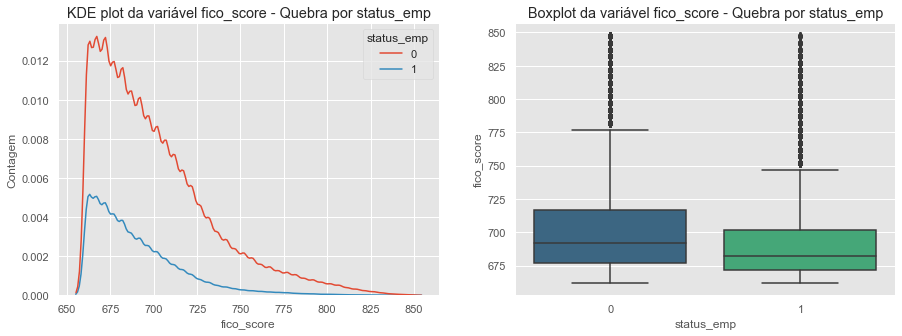

In [47]:
#plot para análise univariada
plot_univariate_continuos_var(df3, "fico_score", color_dist = 'darkmagenta', color_boxplot = 'indigo')

#plot para análise bivariada
plot_bivariate_continuos_var(df3, "fico_score", palette = 'viridis')

Para variável fico_score, podemos observar que a maioria dos clientes da Lending Club tem score FICO entre 650 a 750 (este índice possui intervalo entre 300 e 850). Pelo boxplot podemos ver que existem alguns outliers se aproximando do valor máximo do FICO.

Na análise bivariada, podemos observar que a taxa de inadimplência se concentra nos clientes com índice FICO de 650 a 700 e depois vem caindo.

**fico_score é interessante -> Sim**

### 7. linhas_cred_abertas

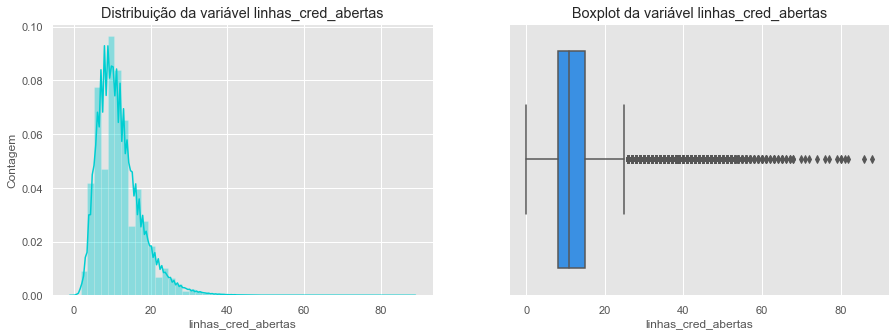

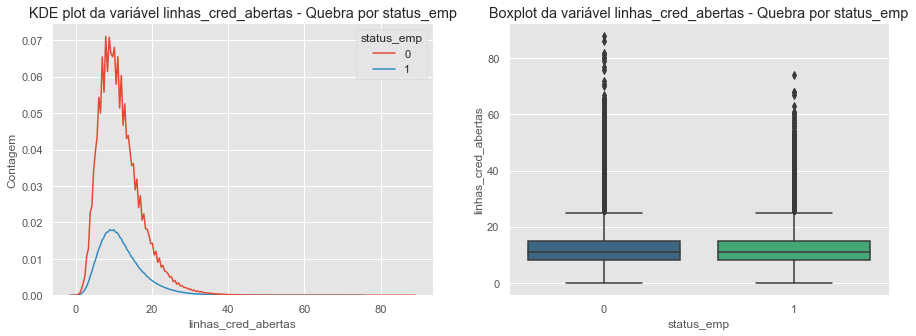

In [48]:
#plot para análise univariada
plot_univariate_continuos_var(df3, "linhas_cred_abertas", color_dist = 'darkturquoise', color_boxplot = 'dodgerblue')

#plot para análise bivariada
plot_bivariate_continuos_var(df3, "linhas_cred_abertas", palette = 'viridis')

Para variável linhas de crédito contínuas, podemos observar no primeiro plot (histograma) que a maioria dos empréstimos se concentra entre 0 e 20 linhas de crédito abertas para o mesmo cliente, porém, pelo boxplot podemos observar uma quantidade interessante de outliers.

Na análise de bivariada, observamos que no primeiro plot os clientes inadimplentes se concentram nessa distribuição entre 0 e 20 linhas de crédito abertas. No boxplot, podemos ver que as medianas estão bem próximas, mas são poucos as conclusões que podemos tirar em relação a essa variável.

**open_acc é interessante -> Não**

### 8. reg_pub_depreciativos

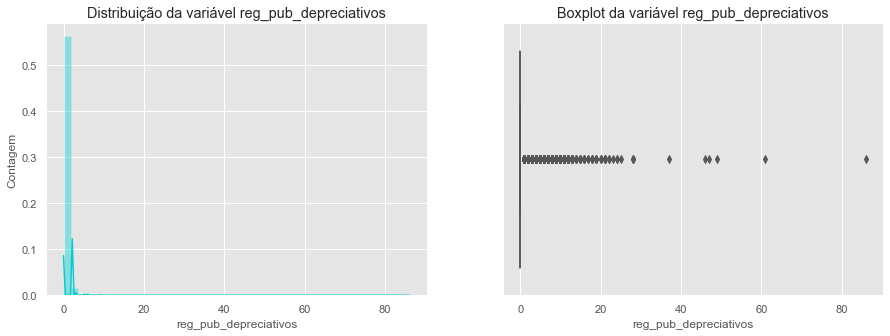

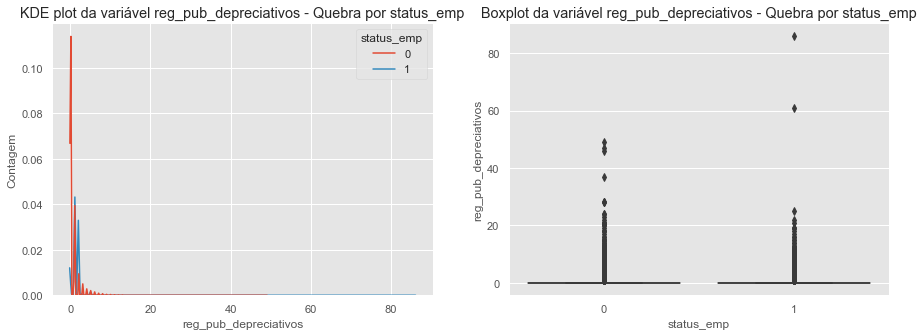

In [49]:
#plot para análise univariada
plot_univariate_continuos_var(
    df3, 
    'reg_pub_depreciativos', 
    color_dist = 'darkturquoise', 
    color_boxplot = 'dodgerblue'
)

#plot para análise bivariada
plot_bivariate_continuos_var(df3, 'reg_pub_depreciativos', palette = 'viridis' )

Para a variável reg_pub_depreciativos, podemos observar que a maioria dos contratantes de empréstimo não apresentam registros públicos depreciativos.

Na análise bivariada, podemos observar que a taxa de inadimplentes acompanha os valores de 0, mas são muito menores em comparação.

**pub_rec é interessante -> Não**

### 9. saldo_rot_total

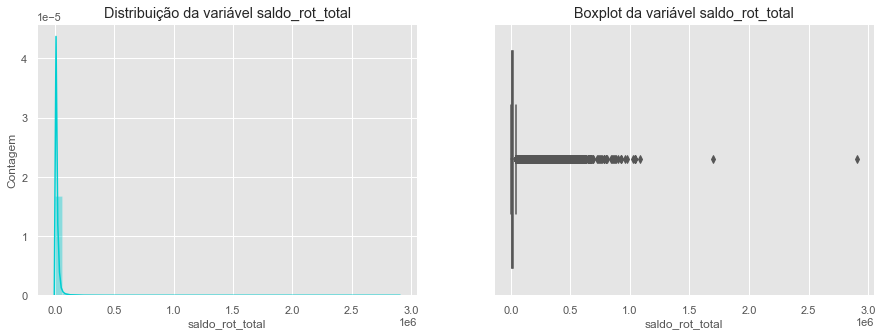

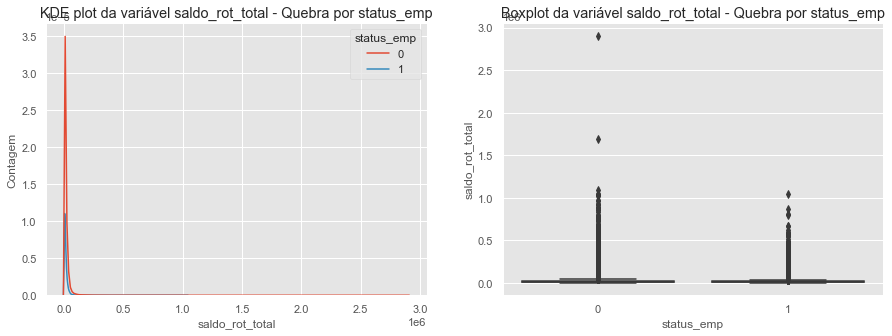

In [50]:
#plot para análise univariada
plot_univariate_continuos_var(df3, "saldo_rot_total", color_dist = 'darkturquoise', color_boxplot = 'dodgerblue')

#plot para análise bivariada
plot_bivariate_continuos_var(df3, "saldo_rot_total", palette = 'viridis')

### 10. taxa_uso_linha_rot

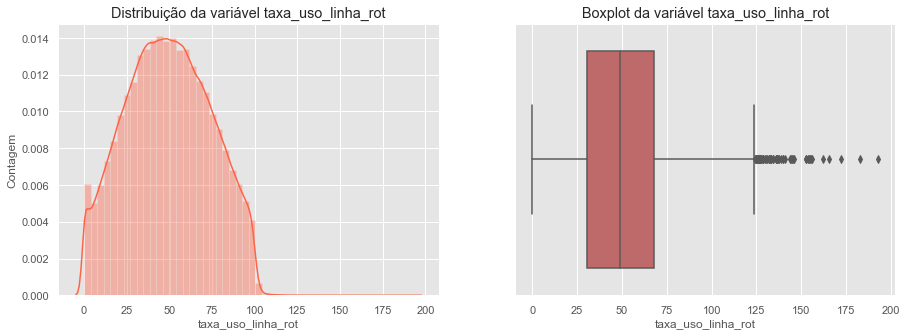

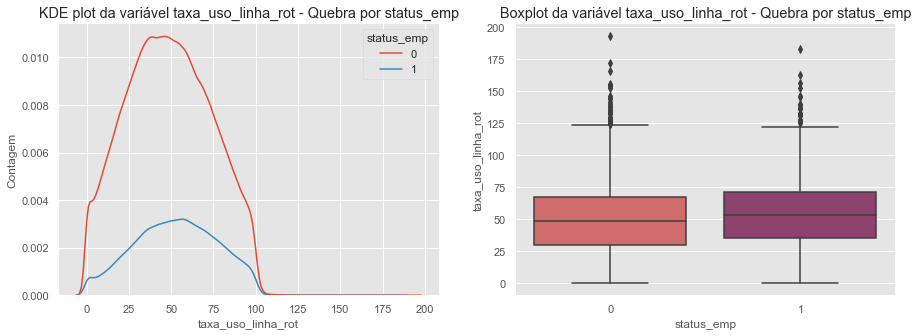

In [51]:
#plot para análise univariada
plot_univariate_continuos_var(df3, "taxa_uso_linha_rot", color_dist = 'tomato', color_boxplot = 'indianred')

#plot para análise bivariada
plot_bivariate_continuos_var(df3, "taxa_uso_linha_rot", palette = 'flare')

Para variável taxa_uso_linha_rot, podemos observar que esta tem uma distribuição que se assemelha à distribuição normal, concentrando seus valores num intervalo entre 0 e 100. Além disso, no boxplot podemos observar melhor os outliers.

Do gráfico acima para ‘taxa_uso_linha_rot’ podemos inferir que a taxa de inadimplentes está flutuando onde alguns têm uma relação completa de 100% para o inadimplente e está aumentando conforme a magnitude aumenta, portanto, o evento pode ter correlação com a variável revol_util

**taxa_uso_linha_rot é interessante -> Sim**

### 11. total_linha_cred_abertas

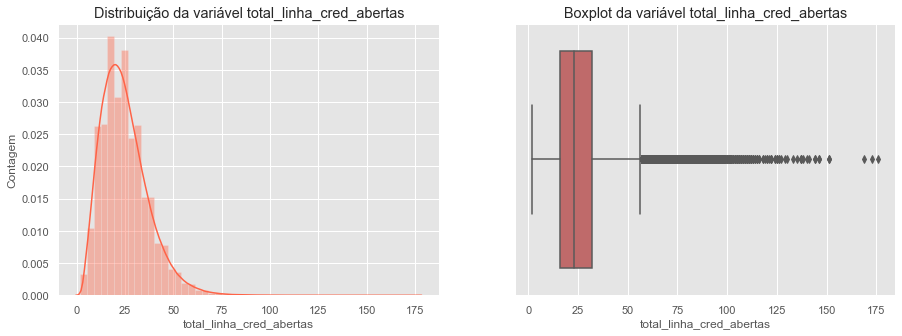

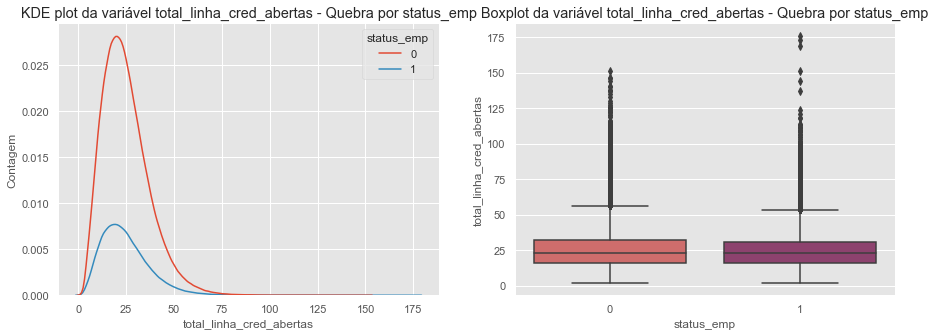

In [52]:
#plot para análise univariada
plot_univariate_continuos_var(df3, "total_linha_cred_abertas", color_dist = 'tomato', color_boxplot = 'indianred')

#plot para análise bivariada
plot_bivariate_continuos_var(df3, "total_linha_cred_abertas", palette = 'flare')

Do gráfico acima para ‘total_linha_cred_abertas’ podemos inferir que a taxa dos inadimplentes é quase constante para todos os valores total_linha_cred_abertas, portanto, o evento pode não ter correlação com a variável total_linha_cred_abertas


**total_linha_cred_abertas é interessante -> Não**

### 12. linhas_abertas_m6

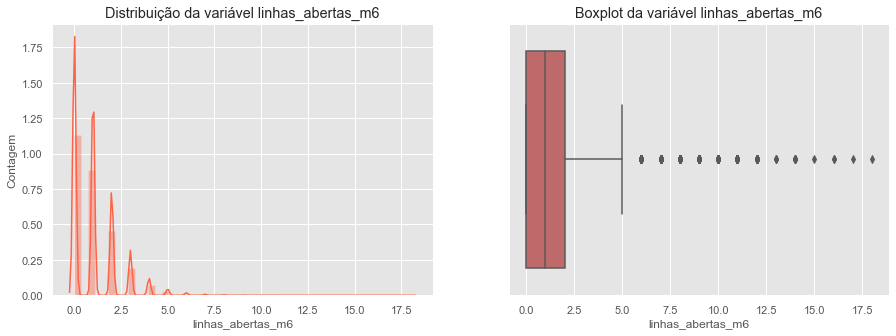

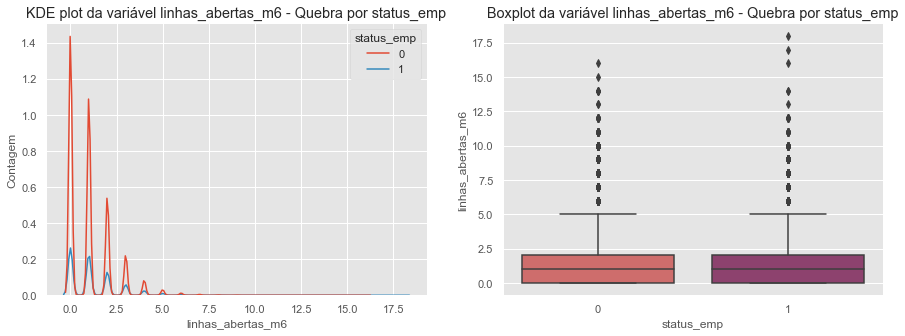

In [53]:
#plot para análise univariada
plot_univariate_continuos_var(df3, "linhas_abertas_m6", color_dist = 'tomato', color_boxplot = 'indianred')

#plot para análise bivariada
plot_bivariate_continuos_var(df3, "linhas_abertas_m6", palette = 'flare')

### 13. prest_abertas

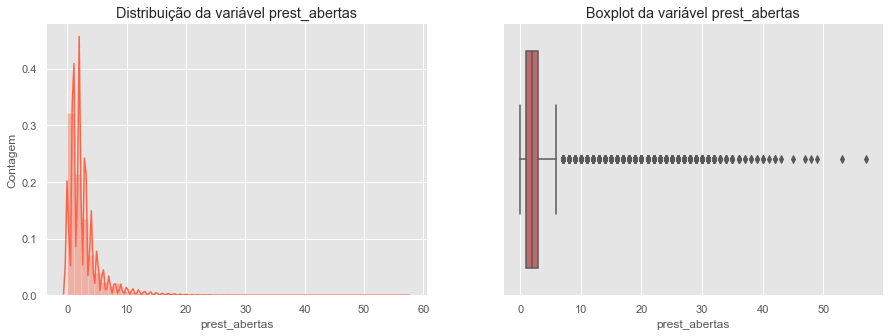

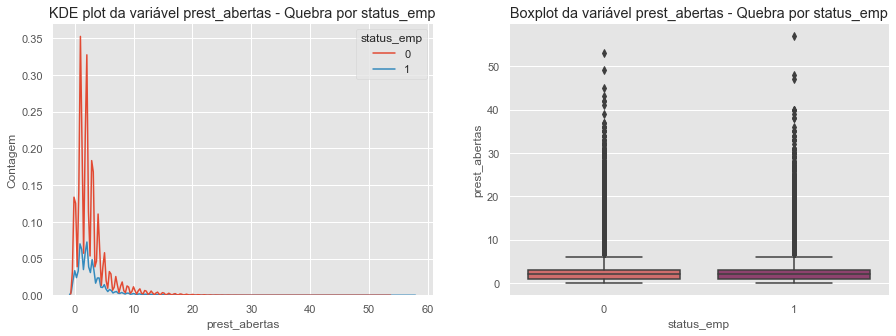

In [54]:
#plot para análise univariada
plot_univariate_continuos_var(df3, "prest_abertas", color_dist = 'tomato', color_boxplot = 'indianred')

#plot para análise bivariada
plot_bivariate_continuos_var(df3, "prest_abertas", palette = 'flare')

### 14.prest_abertas_m12

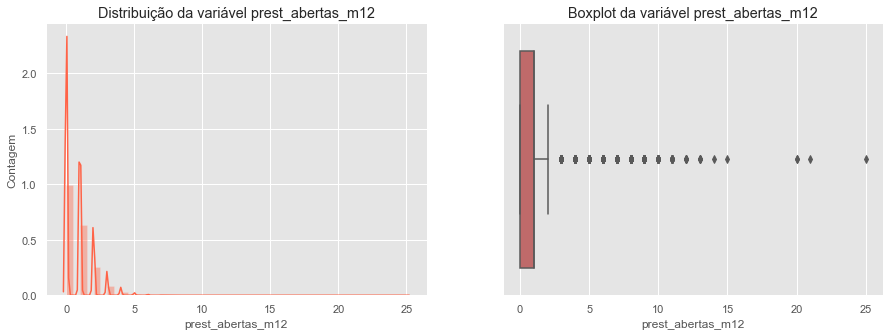

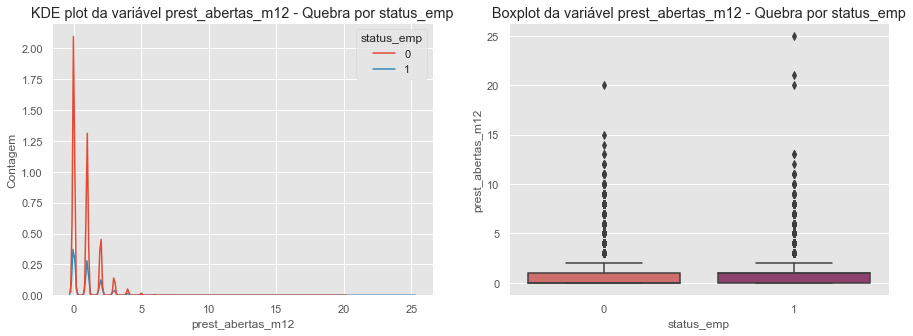

In [55]:
#plot para análise univariada
plot_univariate_continuos_var(df3, "prest_abertas_m12", color_dist = 'tomato', color_boxplot = 'indianred')

#plot para análise bivariada
plot_bivariate_continuos_var(df3, "prest_abertas_m12", palette = 'flare')

### 15.prest_abertas_m24

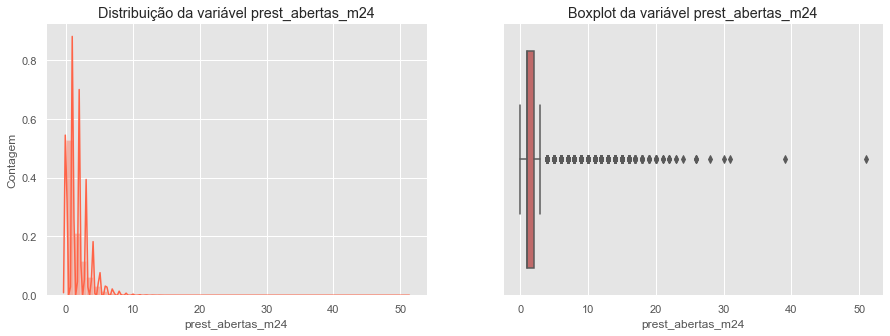

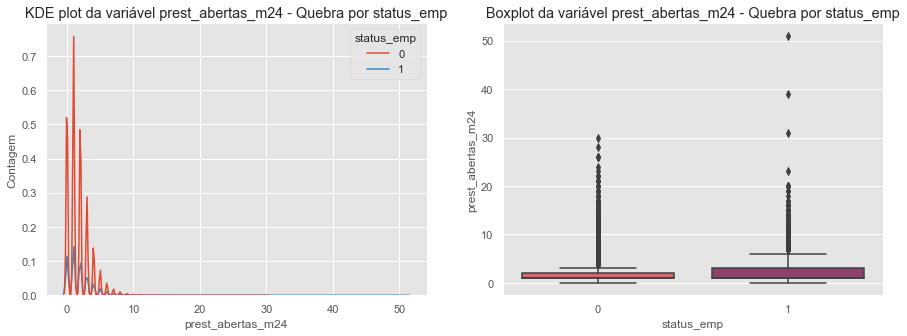

In [56]:
#plot para análise univariada
plot_univariate_continuos_var(df3, "prest_abertas_m24", color_dist = 'tomato', color_boxplot = 'indianred')

#plot para análise bivariada
plot_bivariate_continuos_var(df3, "prest_abertas_m24", palette = 'flare')

### 16. meses_ultimo_cred

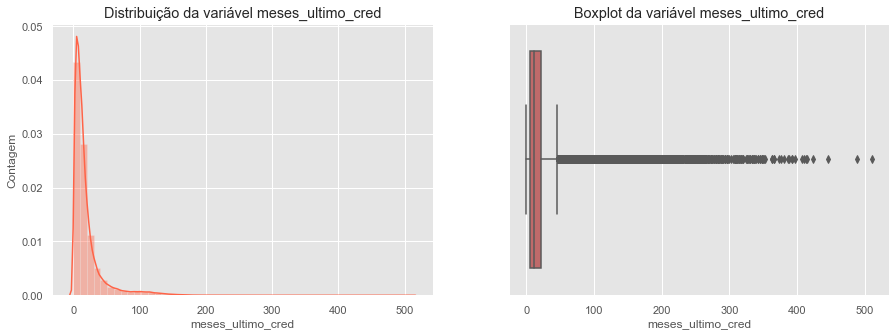

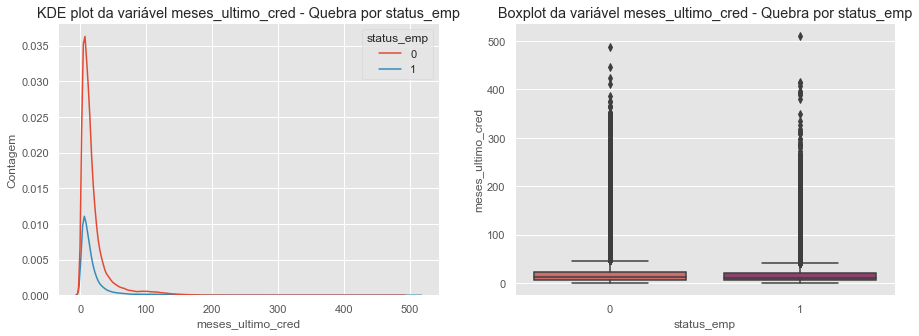

In [57]:
#plot para análise univariada
plot_univariate_continuos_var(df3, "meses_ultimo_cred", color_dist = 'tomato', color_boxplot = 'indianred')

#plot para análise bivariada
plot_bivariate_continuos_var(df3, "meses_ultimo_cred", palette = 'flare')

### 17. saldo_contas_prest

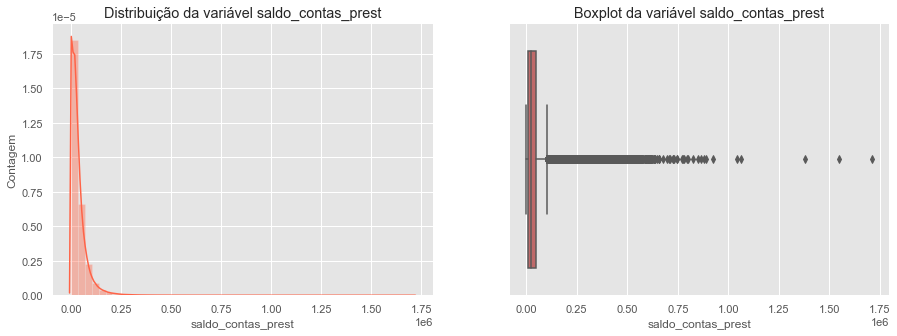

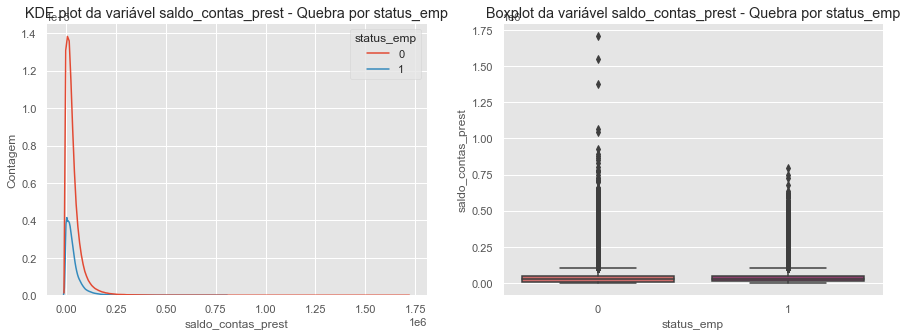

In [58]:
#plot para análise univariada
plot_univariate_continuos_var(df3, "saldo_contas_prest", color_dist = 'tomato', color_boxplot = 'indianred')

#plot para análise bivariada
plot_bivariate_continuos_var(df3, "saldo_contas_prest", palette = 'flare')

### 18. razao_saldo_lim_cred

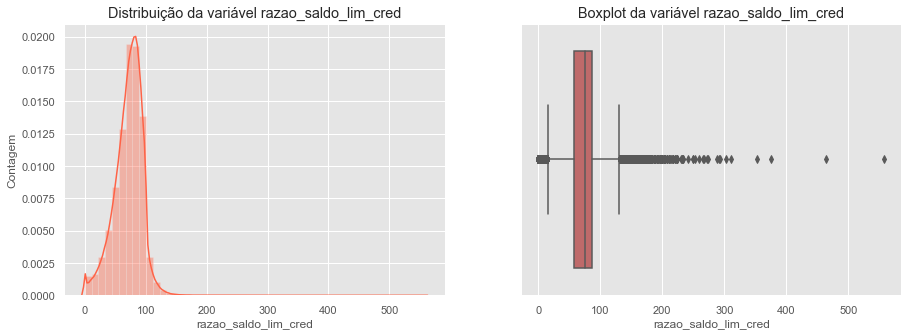

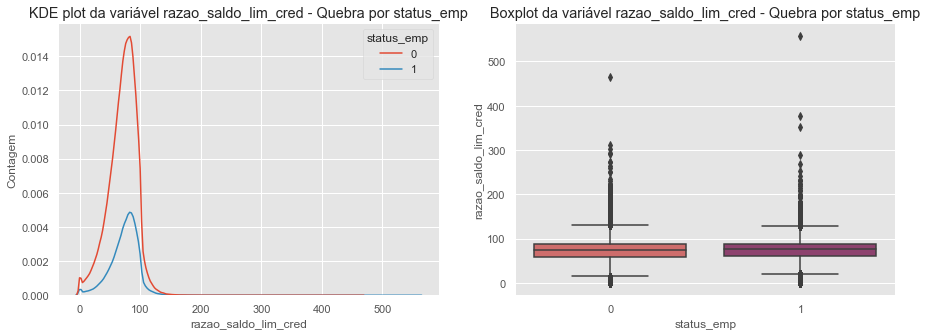

In [59]:
#plot para análise univariada
plot_univariate_continuos_var(df3, "razao_saldo_lim_cred", color_dist = 'tomato', color_boxplot = 'indianred')

#plot para análise bivariada
plot_bivariate_continuos_var(df3, "razao_saldo_lim_cred", palette = 'flare')

### 19. negociacoes_abertas_m12

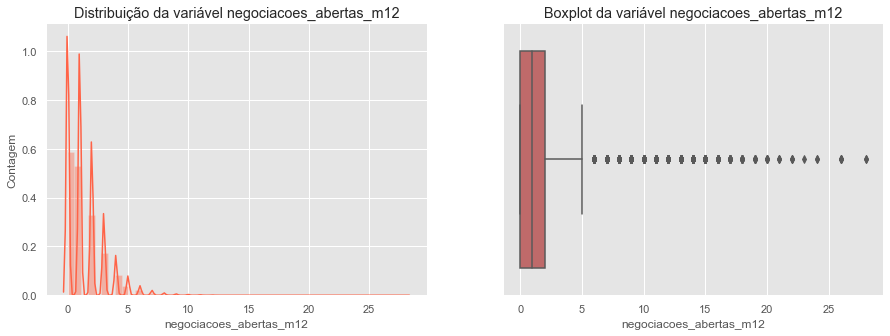

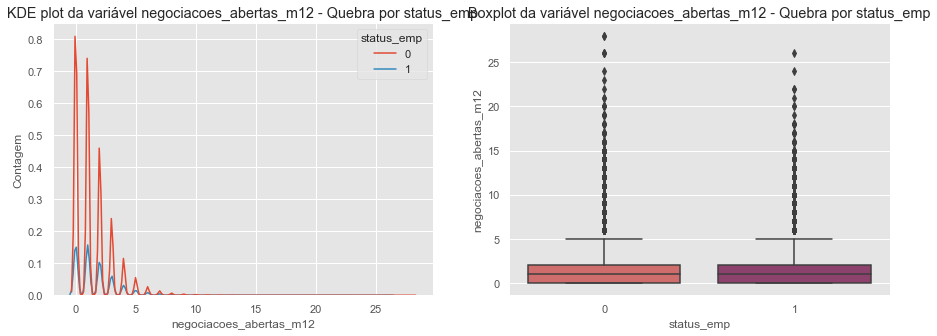

In [60]:
#plot para análise univariada
plot_univariate_continuos_var(df3, "negociacoes_abertas_m12", color_dist = 'tomato', color_boxplot = 'indianred')

#plot para análise bivariada
plot_bivariate_continuos_var(df3, "negociacoes_abertas_m12", palette = 'flare')

### 20. negociacoes_abertas_m24

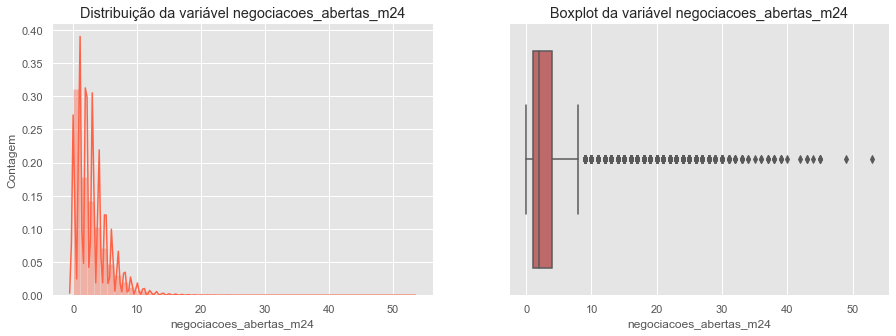

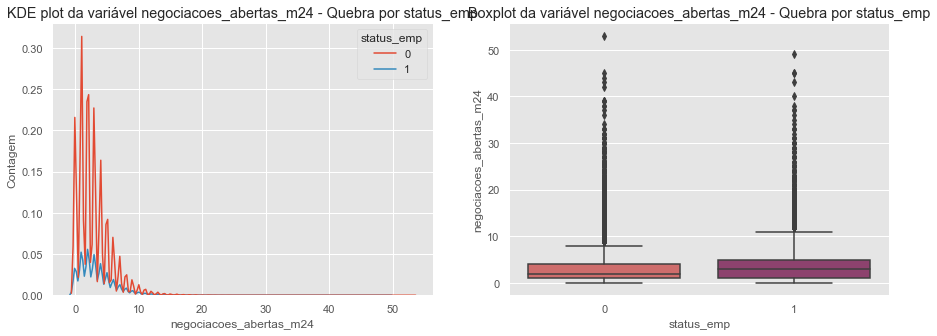

In [61]:
#plot para análise univariada
plot_univariate_continuos_var(df3, "negociacoes_abertas_m24", color_dist = 'tomato', color_boxplot = 'indianred')

#plot para análise bivariada
plot_bivariate_continuos_var(df3, "negociacoes_abertas_m24", palette = 'flare')

### 21. saldo_atual_max

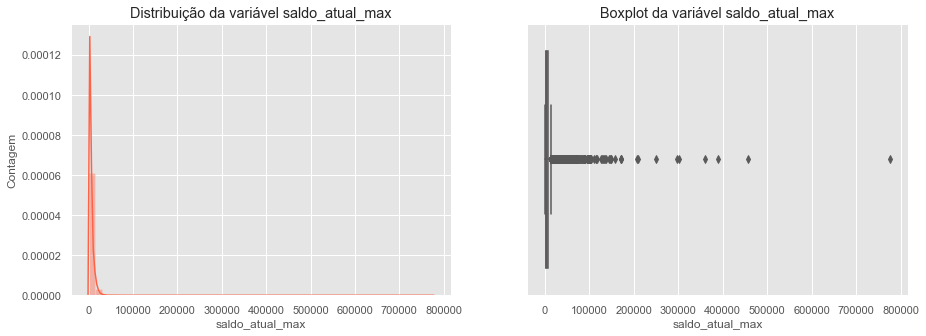

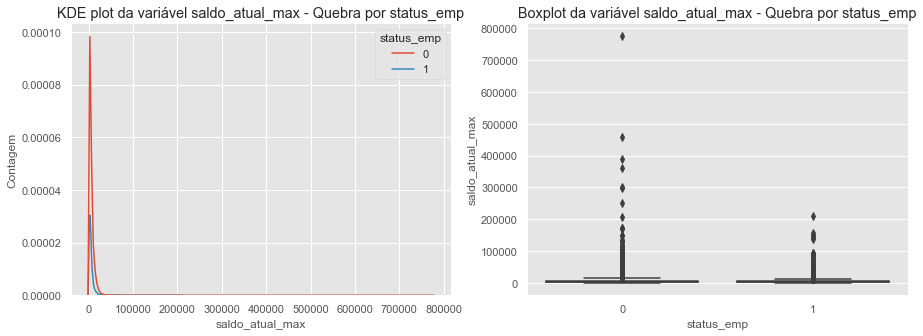

In [62]:
#plot para análise univariada
plot_univariate_continuos_var(df3, "saldo_atual_max", color_dist = 'tomato', color_boxplot = 'indianred')

#plot para análise bivariada
plot_bivariate_continuos_var(df3, "saldo_atual_max", palette = 'flare')

### 22. saldo_cred

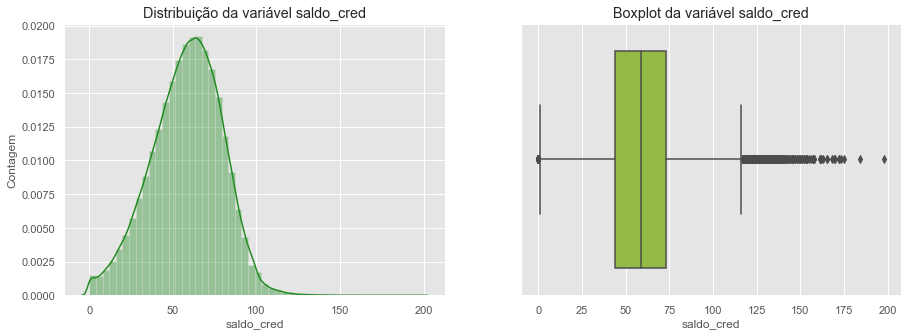

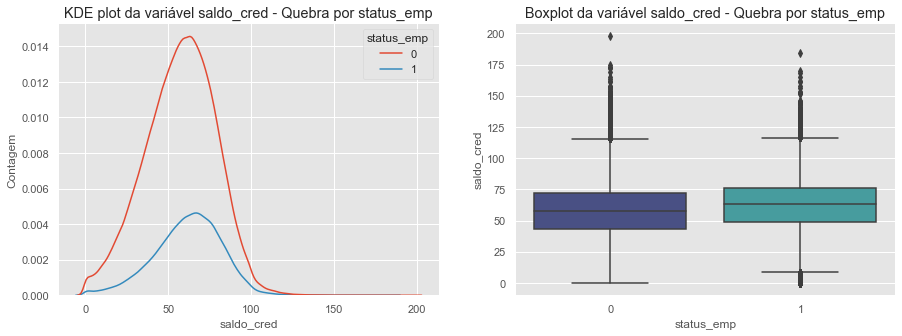

In [63]:
#plot para análise univariada
plot_univariate_continuos_var(df3, "saldo_cred", color_dist = 'forestgreen', color_boxplot = 'yellowgreen')

#plot para análise bivariada
plot_bivariate_continuos_var(df3, "saldo_cred", palette = 'mako')

### 23. qtd_consultas_cred

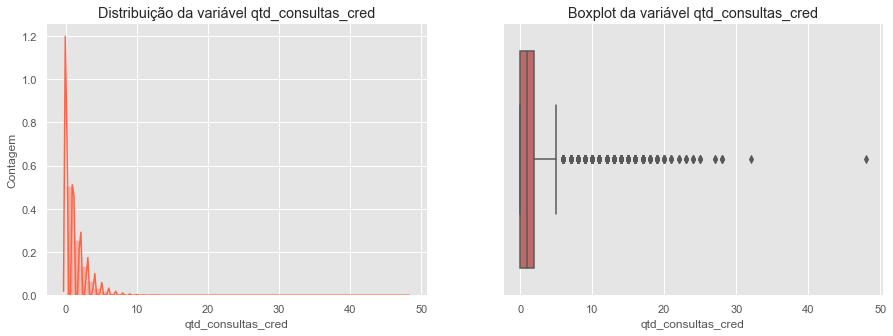

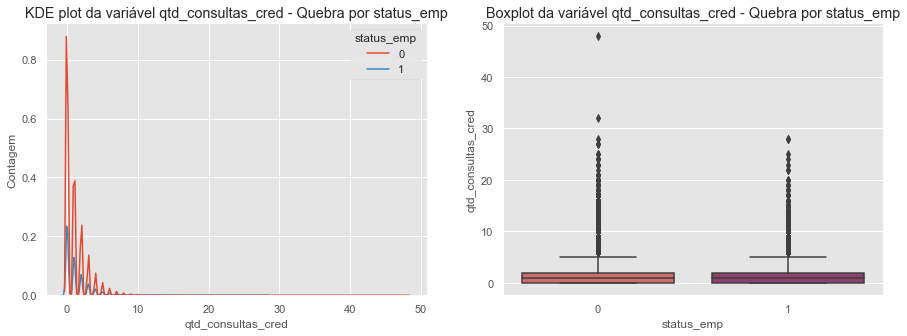

In [64]:
#plot para análise univariada
plot_univariate_continuos_var(df3, "qtd_consultas_cred", color_dist = 'tomato', color_boxplot = 'indianred')

#plot para análise bivariada
plot_bivariate_continuos_var(df3, "qtd_consultas_cred", palette = 'flare')

### 25. qtd_negociacoes_cred

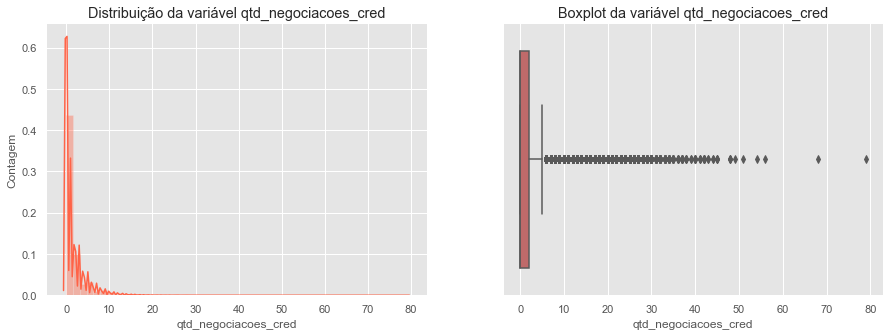

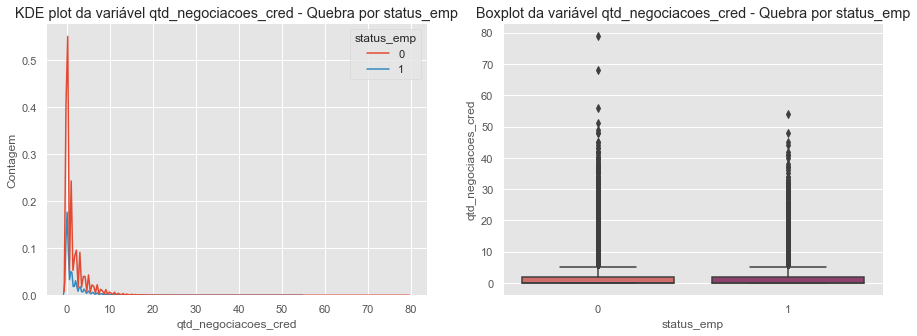

In [65]:
#plot para análise univariada
plot_univariate_continuos_var(df3, "qtd_negociacoes_cred", color_dist = 'tomato', color_boxplot = 'indianred')

#plot para análise bivariada
plot_bivariate_continuos_var(df3, "qtd_negociacoes_cred", palette = 'flare')

### 26. qtd_consultas_cred_m12

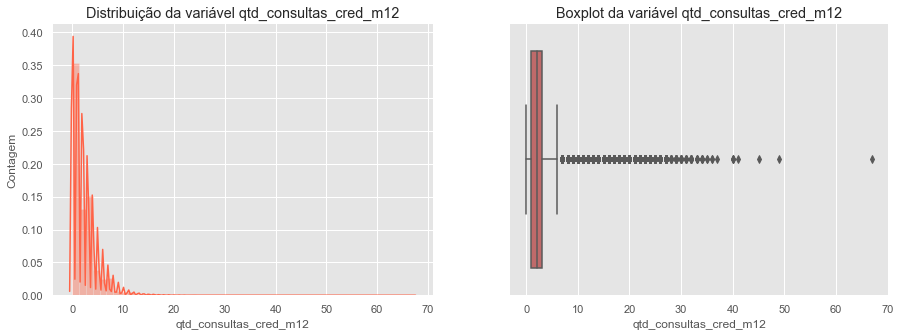

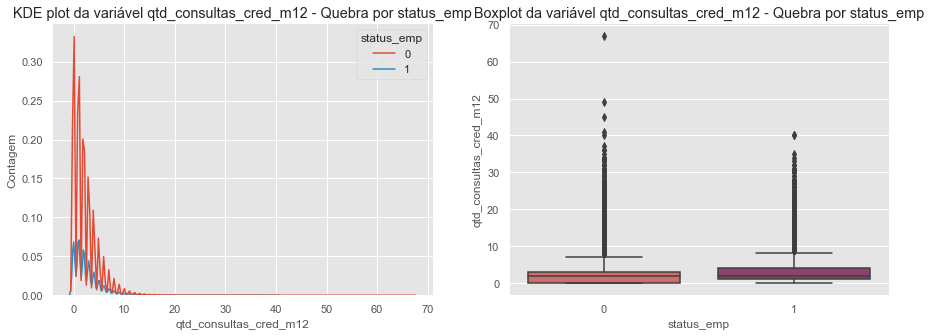

In [66]:
#plot para análise univariada
plot_univariate_continuos_var(df3, "qtd_consultas_cred_m12", color_dist = 'tomato', color_boxplot = 'indianred')

#plot para análise bivariada
plot_bivariate_continuos_var(df3, "qtd_consultas_cred_m12", palette = 'flare')

### 27. meses_primeira_abert_prestacoes

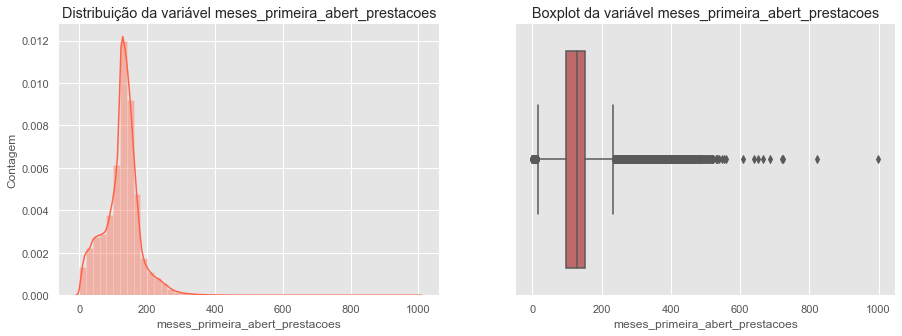

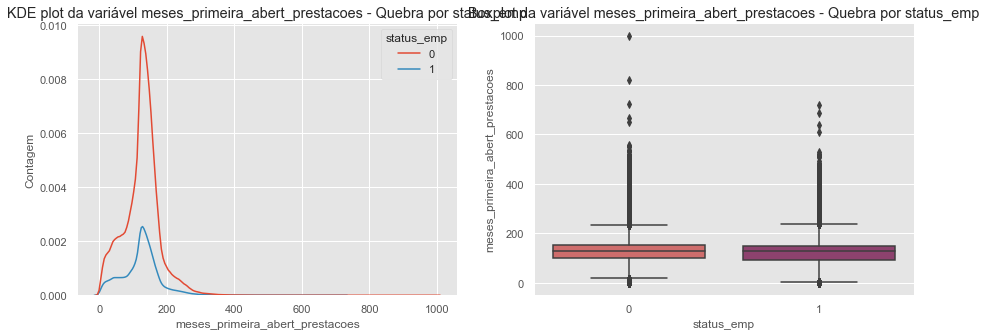

In [67]:
#plot para análise univariada
plot_univariate_continuos_var(df3, "meses_primeira_abert_prestacoes", color_dist = 'tomato', color_boxplot = 'indianred')

#plot para análise bivariada
plot_bivariate_continuos_var(df3, "meses_primeira_abert_prestacoes", palette = 'flare')

### 28. meses_primeira_abert_conta_rot

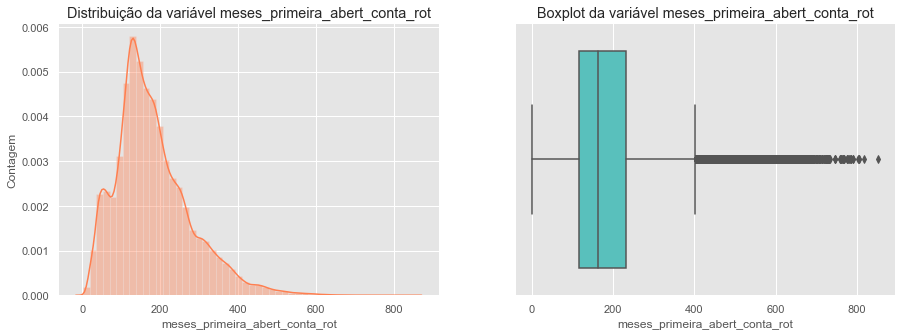

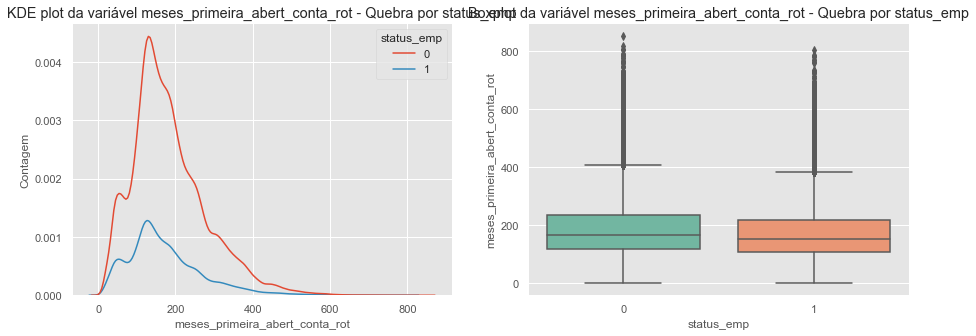

In [68]:
#plot para análise univariada
plot_univariate_continuos_var(df3, "meses_primeira_abert_conta_rot", color_dist = 'coral', color_boxplot = 'mediumturquoise')

#plot para análise bivariada
plot_bivariate_continuos_var(df3, "meses_primeira_abert_conta_rot", palette = 'Set2')

### 29. qtd_hipotecas

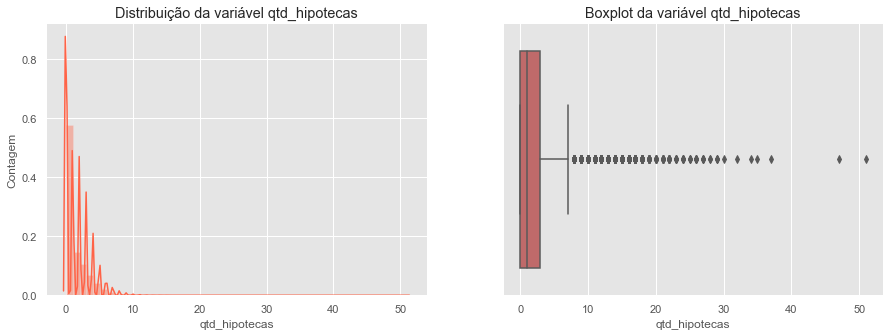

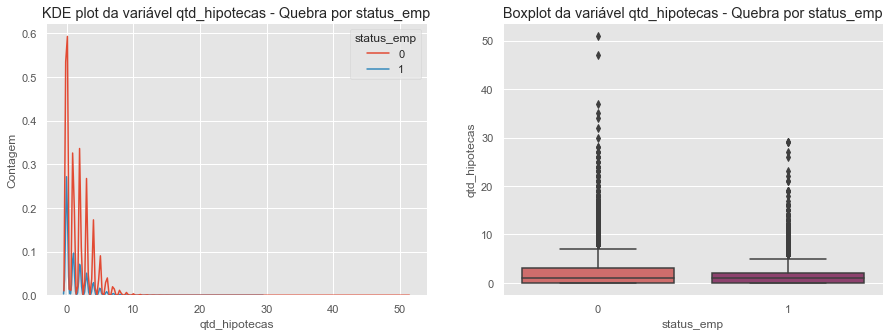

In [69]:
#plot para análise univariada
plot_univariate_continuos_var(df3, "qtd_hipotecas", color_dist = 'tomato', color_boxplot = 'indianred')

#plot para análise bivariada
plot_bivariate_continuos_var(df3, "qtd_hipotecas", palette = 'flare')

### 30. num_falencias

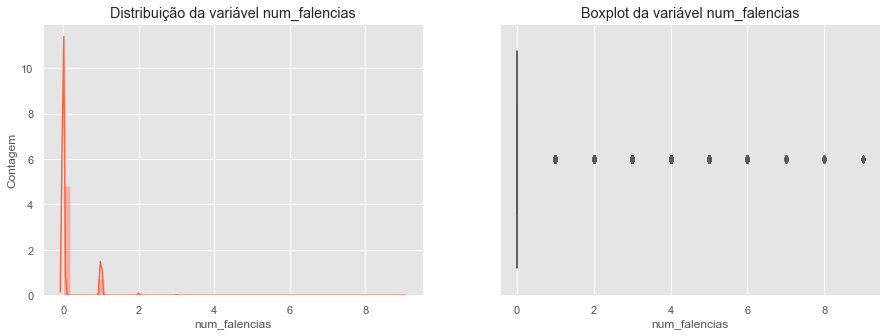

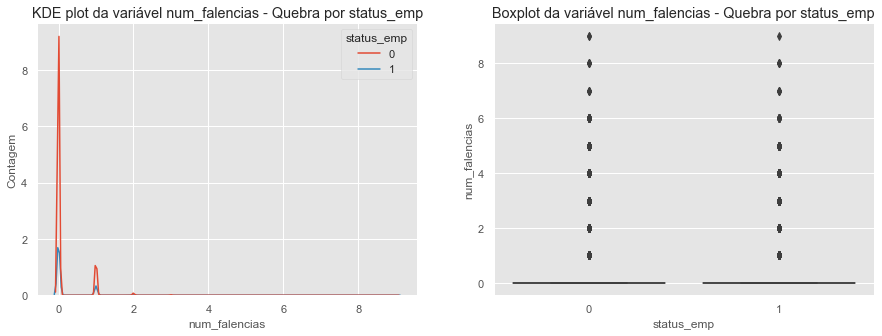

In [70]:
#plot para análise univariada
plot_univariate_continuos_var(df3, "num_falencias", color_dist = 'tomato', color_boxplot = 'indianred')

#plot para análise bivariada
plot_bivariate_continuos_var(df3, "num_falencias", palette = 'flare')

# Análise Multivariada 

## Correlação entre features

In [71]:
df4 = df3.copy()

In [72]:
variaveis = [
    'volume_emp',
    'prazo',
    'taxa_juros',
    'prestacao',
    'score',
    'sub_score',
    'nome_emprego',
    'anos_emprego',
    'casa_propria',
    'renda_anual',
    'status_verificacao',
    'mes_inic_emp',
    'status_emp',
    'url',
    'proposito_emp',
    'titulo_emp',
    'zip_code',
    'estado_endereco',
    'razao_pag_inc',
    'primeira_linha_cred',
    'linhas_cred_abertas',
    'reg_pub_depreciativos',
    'saldo_rot_total',
    'taxa_uso_linha_rot',
    'total_linha_cred_abertas',
    'status_init',
    'tipo_emp',
    'linhas_abertas_m6',
    'prest_abertas',
    'prest_abertas_m12',
    'prest_abertas_m24',
    'meses_ultimo_cred',
    'saldo_contas_prest',
    'razao_saldo_lim_cred',
    'negociacoes_abertas_m12',
    'negociacoes_abertas_m24',
    'saldo_atual_max',
    'saldo_cred',
    'qtd_consultas_cred',
    'qtd_negociacoes_cred',
    'qtd_consultas_cred_m12',
    'meses_primeira_abert_prestacoes',
    'meses_primeira_abert_conta_rot',
    'qtd_hipotecas',
    'num_falencias',
    'fico_score'
]


In [73]:
corr_matrix = df4[variaveis].corr(method = 'spearman')

In [74]:
corr_matrix

volume_emp  taxa_juros  prestacao  renda_anual  status_emp  razao_pag_inc  primeira_linha_cred  linhas_cred_abertas  reg_pub_depreciativos  saldo_rot_total  taxa_uso_linha_rot  total_linha_cred_abertas  linhas_abertas_m6  prest_abertas  prest_abertas_m12  prest_abertas_m24  meses_ultimo_cred  saldo_contas_prest  razao_saldo_lim_cred  negociacoes_abertas_m12  \
volume_emp                             1.00        0.11       0.97         0.48        0.08           0.04                -0.16                 0.20                  -0.08             0.45                0.12                      0.21              -0.02           0.07              -0.00               0.03               0.01                0.16                 -0.09                    -0.03   
taxa_juros                             0.11        1.00       0.13        -0.15        0.28           0.21                 0.15                -0.02                   0.08            -0.03                0.22                     -0.07               0.16           0.05               0.18               0.16              -0.17                0.06                  0.17                     0.14   
prestacao                              0.97        0.13       1.00         0.45        0.07           0.05                -0.14                 0.19                  -0.07             0.44                0.14                      0.19              -0.00           0.07               0.00               0.03               0.00                0.16                 -0.09                    -0.01   
renda_anual                            0.48       -0.15       0.45         1.00       -0.07          -0.22                -0.23                 0.25                  -0.04             0.40                0.08                      0.32               0.07           0.23               0.14               0.20              -0.14                0.35                 -0.08                    -0.00   
status_emp                             0.08        0.28       0.07        -0.07        1.00           0.11                 0.04                 0.03                   0.03            -0.01                0.07                     -0.02               0.06           0.01               0.04               0.03              -0.04                0.01                  0.05                     0.06   
razao_pag_inc                          0.04        0.21       0.05        -0.22        0.11           1.00                -0.05                 0.32                  -0.04             0.26                0.19                      0.25               0.05           0.42               0.21               0.31              -0.22                0.43                 -0.03                     0.01   
primeira_linha_cred                   -0.16        0.15      -0.14        -0.23        0.04          -0.05                 1.00                -0.16                  -0.08            -0.27               -0.05                     -0.33              -0.01           0.01              -0.01              -0.00              -0.01               -0.03                  0.09                     0.01   
linhas_cred_abertas                    0.20       -0.02       0.19         0.25        0.03           0.32                -0.16                 1.00                  -0.01             0.38               -0.14                      0.71               0.26           0.45               0.17               0.26              -0.16                0.38                  0.10                     0.33   
reg_pub_depreciativos                 -0.08        0.08      -0.07        -0.04        0.03          -0.04                -0.08                -0.01                   1.00            -0.18               -0.08                      0.03               0.07          -0.02               0.05               0.06              -0.05               -0.01                  0.03                     0.09   
saldo_rot_total                        0.45       -0.03       0.44       

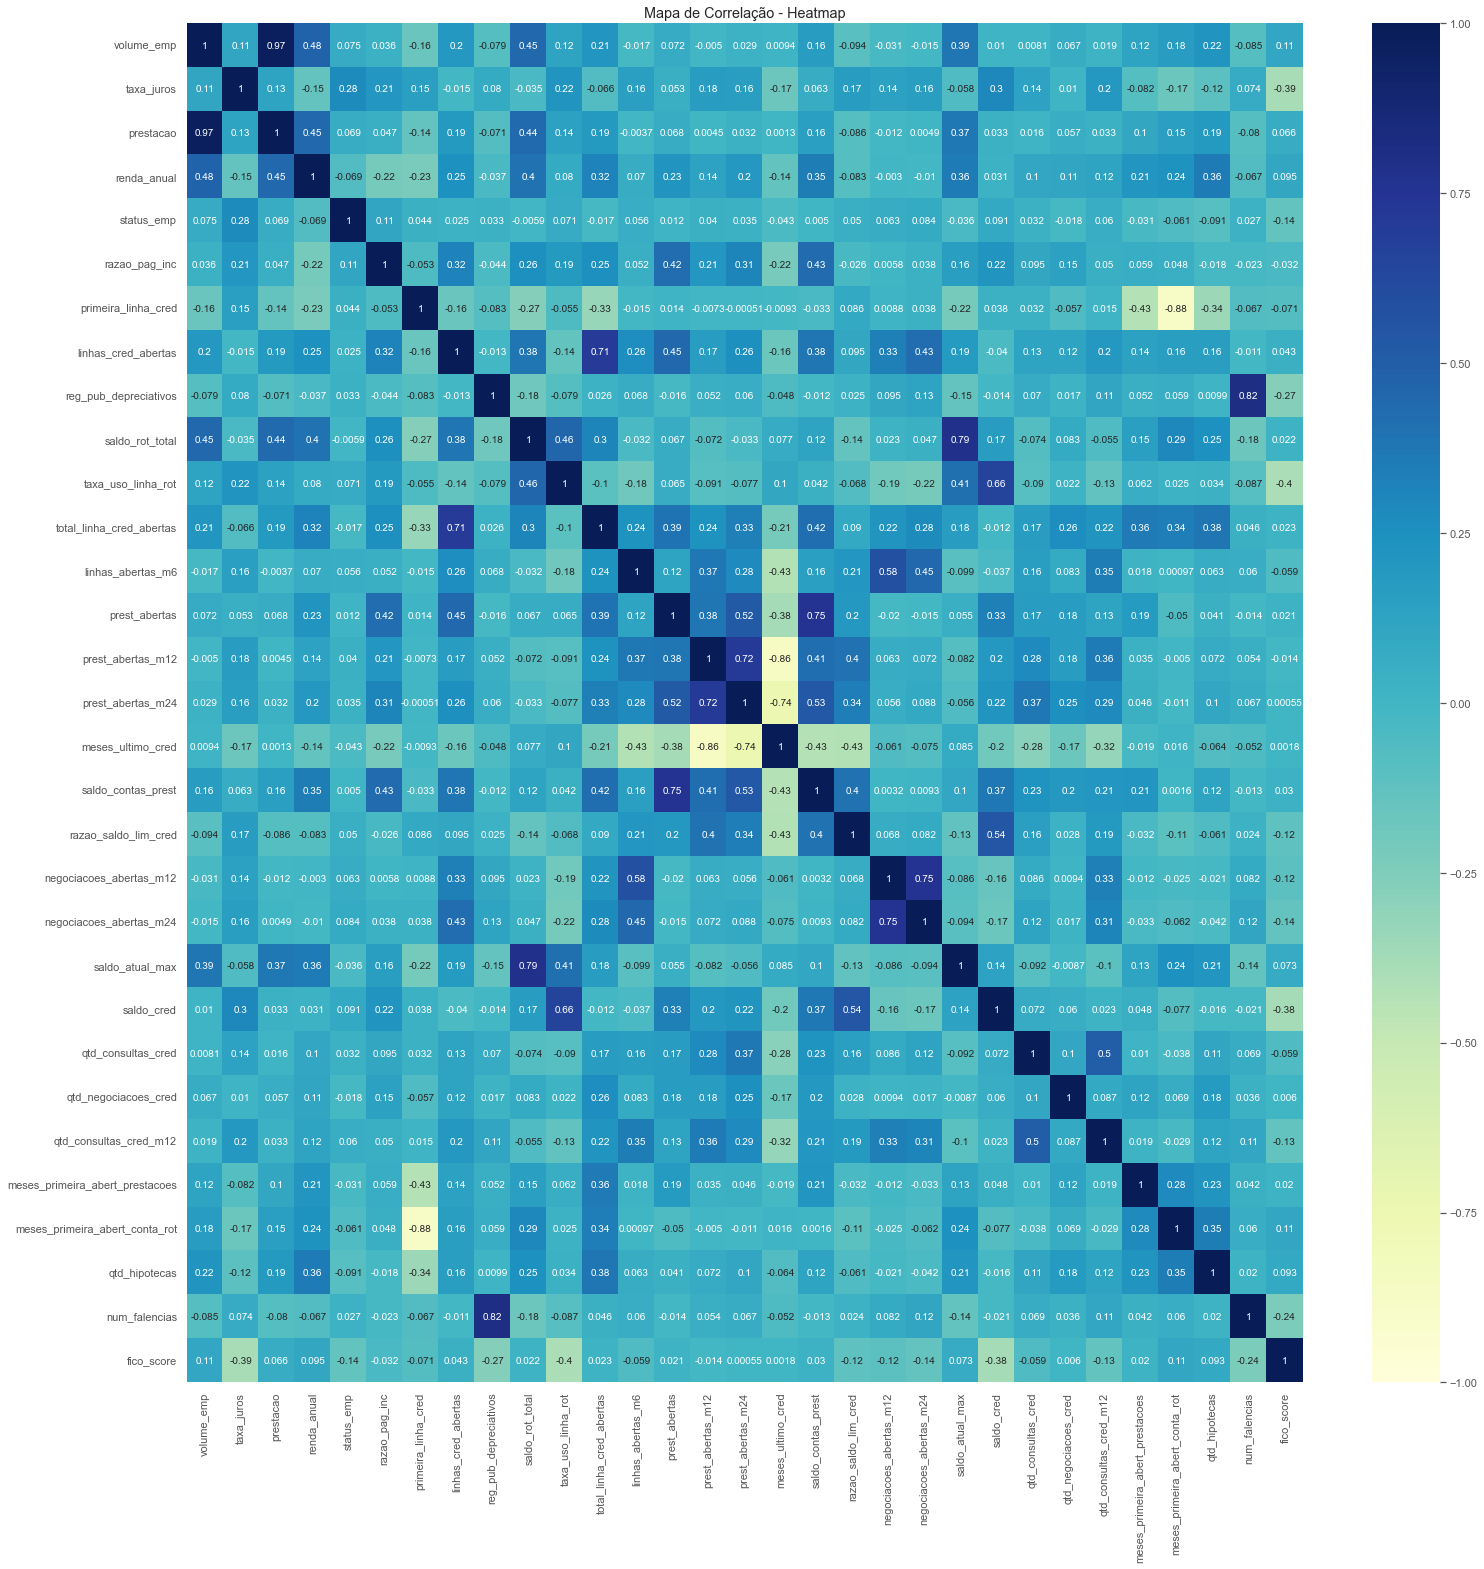

In [75]:
# heat map 
fig = plt.figure(figsize=(25,25))

sns.heatmap(
    corr_matrix,
    vmin=-1.0,
    vmax=1.0,
    annot=True, 
    cmap="YlGnBu"
)
plt.title("Mapa de Correlação - Heatmap")
plt.show()

In [76]:
from tqdm import tqdm

In [77]:
def correlation_feats( df, corr_matrix, threshold ):
    col_corr = set()
    for i in tqdm( range( len( corr_matrix.columns ) ) ):
        for j in range(i):
            col_name = corr_matrix.columns[i]
            row_name = corr_matrix.columns[j]
            
            if np.abs( corr_matrix.iloc[i,j] ) >= threshold and (col_name not in col_corr) and (row_name not in col_corr):
                col_corr.add( col_name )
                if col_name in df.columns:
                    del df[col_name]
    return col_corr
                    

In [78]:
# df_corr = df4[variaveis.index].copy()

In [79]:
corr_cols_dropped =  correlation_feats( df4, corr_matrix, 0.6)

100%|██████████| 31/31 [00:01<00:00, 24.02it/s]


In [80]:
len(corr_cols_dropped)

10

In [81]:
print(corr_cols_dropped)

{'negociacoes_abertas_m24', 'prestacao', 'total_linha_cred_abertas', 'num_falencias', 'saldo_contas_prest', 'saldo_cred', 'meses_ultimo_cred', 'meses_primeira_abert_conta_rot', 'prest_abertas_m24', 'saldo_atual_max'}


In [82]:
df4.shape

(862074, 38)

In [83]:
df4.columns.tolist()

['id',
 'volume_emp',
 'prazo',
 'taxa_juros',
 'score',
 'sub_score',
 'nome_emprego',
 'anos_emprego',
 'casa_propria',
 'renda_anual',
 'status_verificacao',
 'mes_inic_emp',
 'status_emp',
 'url',
 'proposito_emp',
 'titulo_emp',
 'zip_code',
 'estado_endereco',
 'razao_pag_inc',
 'primeira_linha_cred',
 'linhas_cred_abertas',
 'reg_pub_depreciativos',
 'saldo_rot_total',
 'taxa_uso_linha_rot',
 'status_init',
 'tipo_emp',
 'linhas_abertas_m6',
 'prest_abertas',
 'prest_abertas_m12',
 'razao_saldo_lim_cred',
 'negociacoes_abertas_m12',
 'qtd_consultas_cred',
 'qtd_negociacoes_cred',
 'qtd_consultas_cred_m12',
 'meses_primeira_abert_prestacoes',
 'qtd_hipotecas',
 'emprego_categoria',
 'fico_score']

In [84]:
df4.drop(['url', 'zip_code'], axis = 1, inplace = True)

Pelo gráfico de correlação, podemos observar algumas variáveis que apresentam alta correlação entre si, e podem influenciar na resposta do modelo quando utilizadas juntas. Por isso, apenas uma variável de cada será mantida.

# Medidas de posição

In [85]:
df5 = df4.copy()

In [86]:
num_vars.columns.tolist()

['id',
 'volume_emp',
 'taxa_juros',
 'prestacao',
 'renda_anual',
 'status_emp',
 'razao_pag_inc',
 'fico_lim_min',
 'fico_lim_max',
 'linhas_cred_abertas',
 'reg_pub_depreciativos',
 'saldo_rot_total',
 'taxa_uso_linha_rot',
 'total_linha_cred_abertas',
 'linhas_abertas_m6',
 'prest_abertas',
 'prest_abertas_m12',
 'prest_abertas_m24',
 'meses_ultimo_cred',
 'saldo_contas_prest',
 'razao_saldo_lim_cred',
 'negociacoes_abertas_m12',
 'negociacoes_abertas_m24',
 'saldo_atual_max',
 'saldo_cred',
 'qtd_consultas_cred',
 'qtd_negociacoes_cred',
 'qtd_consultas_cred_m12',
 'meses_primeira_abert_prestacoes',
 'meses_primeira_abert_conta_rot',
 'qtd_hipotecas',
 'num_falencias']

In [87]:
stats = df5.describe().T
stats['coef_var'] = stats['std']/stats['mean']
stats = stats.T

In [88]:
stats

id  volume_emp  taxa_juros  renda_anual  status_emp  razao_pag_inc  primeira_linha_cred  linhas_cred_abertas  reg_pub_depreciativos  saldo_rot_total  taxa_uso_linha_rot  linhas_abertas_m6  prest_abertas  prest_abertas_m12  razao_saldo_lim_cred  negociacoes_abertas_m12  qtd_consultas_cred  qtd_negociacoes_cred  qtd_consultas_cred_m12  meses_primeira_abert_prestacoes  \
count       862074.00   862074.00   862074.00    862074.00   862074.00      861700.00            862074.00            862074.00              862074.00        862074.00           861517.00          537635.00      537636.00          537636.00             465047.00                537636.00           537636.00             537635.00               537635.00                        838042.00   
mean      79776050.63    14527.34       12.97     77941.55        0.22          18.84              1999.47                11.81                   0.24         16329.47               49.46               1.05           2.79               0.78                 71.42                     1.42                1.09                  1.61                    2.31                           125.31   
std       26155181.82     8958.65        4.96     76662.05        0.41          12.59                 7.69                 5.71                   0.64         23413.28               24.65               1.21           2.99               0.99                 22.91                     1.57                1.59                  2.83                    2.54                            52.72   
min          55716.00     1000.00        5.31         0.00        0.00          -1.00              1934.00                 0.00                   0.00             0.00                0.00               0.00           0.00               0.00                  0.00                     0.00                0.00                  0.00                    0.00                             0.00   
25%       59779404.75     7600.00        9.17     47000.00        0.00          12.05              1996.00                 8.00                   0.00          5711.00               30.70               0.00           1.00               0.00                 58.00                     0.00                0.00                  0.00                    1.00                            97.00   
50%       74532958.50    12000.00       12.29     65000.00        0.00          18.05              2001.00                11.00                   0.00         10831.00               49.10               1.00           2.00               1.00                 75.00                     1.00                1.00                  0.00                    2.00                           129.00   
75%       96633391.75    20000.00       15.61     93000.00        0.00          24.78              2005.00                15.00                   0.00         19487.00               68.10               2.00           3.00               1.00                 87.00                     2.00                2.00                  2.00                    3.00                           152.00   
max      145636374.00    40000.00       30.99  10999200.00        1.00         999.00              2015.00                88.00                  86.00       2904836.00              193.00              18.00          57.00              25.00                558.00                    28.00               48.00                 79.00                   67.00                           999.00   
coef_var         0.33        0.62        0.38         0.98        1.91           0.67                 0.00                 0.48                   2.64             1.43                0.50               1.15           1.07               1.28                  0.32                     1.11                1.45                  1.76                    1.10                             0.42   

          qtd_hipotecas  fico_score  
count         862074.00   862074.00  
mean               1.59      698.32  
std 

In [95]:
#stats.to_excel('stats_lending_club.xlsx')

# Tabela de frequência

In [90]:
cat_vars = [
    'prazo',
     'score',
     'sub_score',
     'emprego_categoria',
     'anos_emprego',
     'casa_propria',
     'status_verificacao',
     #'mes_inic_emp',
     'proposito_emp',
     'titulo_emp',
     'estado_endereco',
     'status_init',
     'tipo_emp'
]

num_vars = [
    #'id',
     'volume_emp',
     'taxa_juros',
     'renda_anual',
     'status_emp',
     'razao_pag_inc',
     'primeira_linha_cred',
     'linhas_cred_abertas',
     'reg_pub_depreciativos',
     'saldo_rot_total',
     'taxa_uso_linha_rot',
     'linhas_abertas_m6',
     'prest_abertas',
     'prest_abertas_m12',
     'razao_saldo_lim_cred',
     'negociacoes_abertas_m12',
     'qtd_consultas_cred',
     'qtd_negociacoes_cred',
     'qtd_consultas_cred_m12',
     'meses_primeira_abert_prestacoes',
     'qtd_hipotecas',
     'fico_score'
]

prazo
 36 months   0.77
 60 months   0.23
Name: prazo, dtype: float64
______________________________
score
C   0.29
B   0.29
A   0.18
D   0.14
E   0.07
F   0.02
G   0.01
Name: score, dtype: float64
______________________________
sub_score
C1   0.07
B5   0.06
B4   0.06
C2   0.06
C4   0.06
B3   0.06
C3   0.06
B1   0.05
B2   0.05
C5   0.05
A5   0.05
A1   0.04
A4   0.04
D1   0.04
D2   0.03
A2   0.03
A3   0.03
D3   0.03
D4   0.02
D5   0.02
E1   0.02
E2   0.01
E3   0.01
E4   0.01
E5   0.01
F1   0.01
F2   0.00
F3   0.00
F4   0.00
F5   0.00
G1   0.00
G2   0.00
G3   0.00
G4   0.00
G5   0.00
Name: sub_score, dtype: float64
______________________________
emprego_categoria
outro                 0.28
gerencia_diretoria    0.19
area_tecnica          0.17
gerais                0.06
comercial             0.06
autonomo              0.04
engenharia            0.04
financeira            0.03
educacao              0.03
area_medica           0.03
direito               0.02
funcionario publico   0.02
banco 

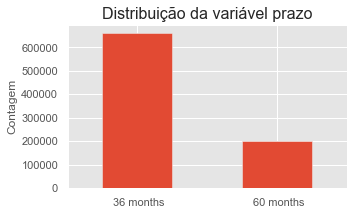

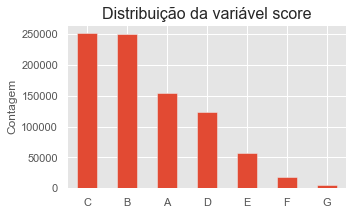

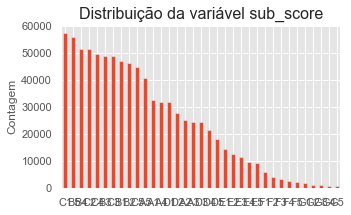

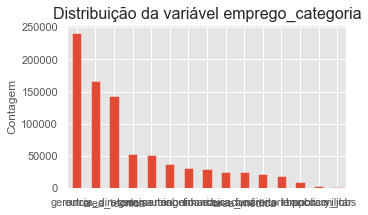

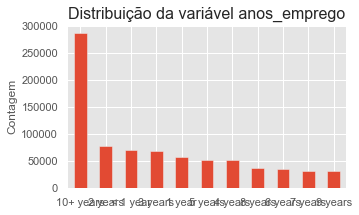

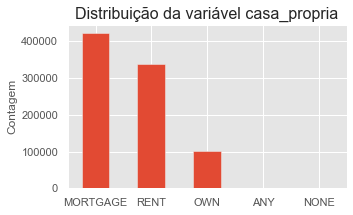

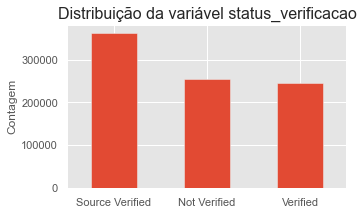

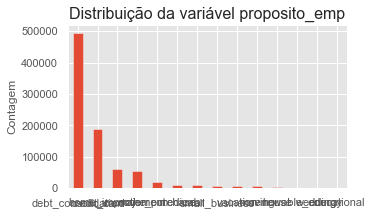

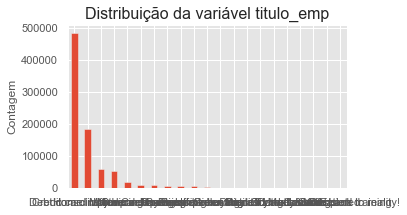

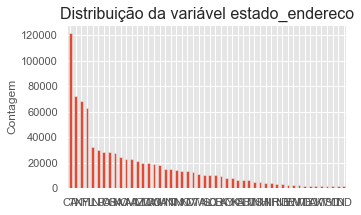

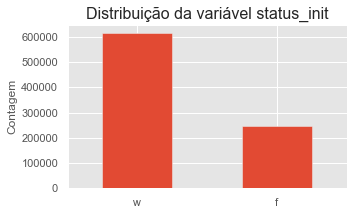

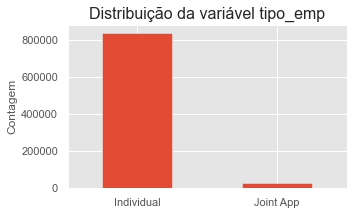

In [91]:
for col in cat_vars:
    print(
        '{}'.format(col)
    )
    print(
        df5[col].value_counts(normalize=True)
    )
    
    fig = plt.figure(figsize=(5,3))
    
    if 'qtde' in col:
        df5[col].dropna().astype(int).value_counts().plot(kind='bar')
    else:
        df5[col].value_counts().plot(kind='bar')
        
        
    plt.title('Distribuição da variável {}'.format(col), fontsize=16)
    plt.ylabel('Contagem', fontsize=12)
    plt.xticks(rotation=0)
    print('______________________________')

# Salvando a base para modelagem

In [92]:
df6 = df5.copy()

In [93]:
print(df6.shape)
df6.head()

(862074, 36)


id  volume_emp       prazo  taxa_juros score sub_score          nome_emprego anos_emprego casa_propria  renda_anual status_verificacao mes_inic_emp  status_emp       proposito_emp          titulo_emp estado_endereco  razao_pag_inc  primeira_linha_cred  linhas_cred_abertas  reg_pub_depreciativos  saldo_rot_total  taxa_uso_linha_rot status_init    tipo_emp  linhas_abertas_m6  \
0  68407277     3600.00   36 months       13.99     C        C4               leadman    10+ years     MORTGAGE     55000.00       Not Verified   2015-12-01           0  debt_consolidation  Debt consolidation              PA           5.91                 2003                 7.00                   0.00          2765.00               29.70           w  Individual               2.00   
1  68355089    24700.00   36 months       11.99     C        C1              engineer    10+ years     MORTGAGE     65000.00       Not Verified   2015-12-01           0      small_business            Business              SD          16.06                 1999                22.00                   0.00         21470.00               19.20           w  Individual               1.00   
2  68341763    20000.00   60 months       10.78     B        B4          truck driver    10+ years     MORTGAGE     63000.00       Not Verified   2015-12-01           0    home_improvement                 NaN              IL          10.78                 2000                 6.00                   0.00          7869.00               56.20           w   Joint App               0.00   
3  68476807    10400.00   60 months       22.45     F        F1   contract specialist      3 years     MORTGAGE    104433.00    Source Verified   2015-12-01           0      major_purchase      Major purchase              PA          25.37                 1998                12.00                   0.00         21929.00               64.50           w  Individual               1.00   
4  68426831    11950.00   36 months       13.44     C        C3  veterinary tecnician      4 years         RENT     34000.00    Source Verified   2015-12-01           0  debt_consolidation  Debt consolidation              GA          10.20                 1987                 5.00                   0.00          8822.00               68.40           w  Individual               0.00   

   prest_abertas  prest_abertas_m12  razao_saldo_lim_cred  negociacoes_abertas_m12  qtd_consultas_cred  qtd_negociacoes_cred  qtd_consultas_cred_m12  meses_primeira_abert_prestacoes  qtd_hipotecas   emprego_categoria  fico_score  
0           2.00               0.00                 36.00                     3.00                3.00                  1.00                    4.00                           148.00           1.00  gerencia_diretoria      677.00  
1           1.00               0.00                 73.00                     2.00                0.00                  0.00                    6.00                           113.00           4.00          engenharia      717.00  
2           1.00               0.00                 73.00                     0.00                2.00                  5.00                    1.00                           125.00           5.00            autonomo      697.00  
3           3.00               0.00                 84.00                     4.00                2.00                  1.00                    3.00                           128.00           6.00        area_tecnica      697.00  
4           1.00               0.00                 99.00                     0.00                0.00                  0.00                    0.00                           338.00           0.00               outro      692.00

In [94]:
df6.to_csv("loan_model_base.csv", index=None)